In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [16]:
start_day_to_analyze = '2020-06-12'
end_day_to_analyze = '2020-06-13'

In [17]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [18]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [19]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [20]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,4291,1501,AKR,buy,587,14.04,"{'avg': 13.7108, 'rsi': 66.92835012827148, 'ma...",2020-06-12 16:58:50.018734+00:00,2020-06-12 16:58:50.338789,13.88,14.38
1,4300,1501,AKR,sell,587,13.86,"{'avg': 13.7424, 'rsi': [33.77245516789455, 32...",2020-06-12 17:40:13.767376+00:00,2020-06-12 17:40:14.255580,13.88,14.38
2,4257,1499,APPS,buy,507,9.37,"{'avg': 9.2253, 'rsi': 69.26129728459809, 'mac...",2020-06-12 16:06:01.241826+00:00,2020-06-12 16:06:01.608347,9.19,9.73
3,4258,1499,APPS,buy,49,9.37,"{'avg': 9.2253, 'rsi': 69.26129728459809, 'mac...",2020-06-12 16:06:01.434860+00:00,2020-06-12 16:06:01.907010,9.19,9.73
4,4269,1499,APPS,sell,556,9.40,"{'avg': 9.2325, 'rsi': [70.66858257878165, 70....",2020-06-12 16:18:08.471864+00:00,2020-06-12 16:18:08.995891,9.19,9.73
...,...,...,...,...,...,...,...,...,...,...,...
189,4285,1498,VSLR,sell,1,9.19,"{'avg': 9.0281, 'rsi': [62.33843237806332, 63....",2020-06-12 16:51:28.585472+00:00,2020-06-12 16:51:29.028732,8.91,9.66
190,4316,1498,VSLR,buy,309,9.24,"{'avg': 9.0549, 'rsi': 67.38052319697144, 'mac...",2020-06-12 18:32:05.432360+00:00,2020-06-12 18:32:05.919229,8.92,9.88
191,4336,1504,VSLR,buy,309,9.24,"{'avg': 9.0549, 'rsi': 67.38052319697144, 'mac...",1498,2020-06-12 18:56:09.431308,8.92,9.88
192,4383,1504,VSLR,sell,154,9.27,"{'avg': 9.0777, 'rsi': [65.86939883064579, 67....",2020-06-12 19:38:13.181205+00:00,2020-06-12 19:38:13.564288,8.92,9.88


In [21]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [22]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1476,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:00.490829,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1477,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:02.342052,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1478,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:04.533503,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1479,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:06.585393,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1480,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:10.031103,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1481,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:12.395317,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1482,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 13:52:20.244927,None,None,d806b006-0fa1-493f-b3df-3c2c9dd64905
1483,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 14:07:42.350973,None,None,831585b5-6fe7-4480-9a63-f81ad93378b9
1484,momentum_long,PAPER,v0.1-511-gc951f0f,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-12 14:07:43.902630,None,None,831585b5-6fe7-4480-9a63-f81ad93378b9


In [23]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [24]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [25]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
6,CLS,1,-7161.00
0,CAMP,7,-5439.13
21,NOVA,3,-4615.62
19,CNCE,1,-4559.28
1,MBI,3,-4532.26
26,SSL,13,-4203.25
25,DSS,1,-3245.13
12,VSLR,13,-2849.14
11,DRRX,1,-1656.48
5,CBD,2,-119.52


TOTAL REVENUE: -39050.73 $ for 7118a934-cb66-4cab-b362-f97e9bf79149


,symbol,count,revenue
6,NOVA,1,-4632.72
0,CAMP,4,-670.30
3,DRRX,2,-78.54
1,DSS,2,-71.40
5,MBI,2,-49.44
10,VSLR,3,-4.68
8,RWT,12,15.44
4,CLS,13,18.20
9,SSL,11,19.25
7,CNCE,2,23.55


TOTAL REVENUE: -5401.76 $ for 8f8d99a6-38f5-42c6-8b86-005f5c7d03d9


,symbol,count,revenue
4,PGEN,2,-487.34
1,VSLR,3,-107.71
3,UNFI,2,-107.36
2,INSG,2,-100.36
0,IMRN,9,53.05


TOTAL REVENUE: -749.72 $ for 121a1799-7192-486a-a26b-3df192d93f7d


In [26]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [27]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

CAMP analysis for run 1501 with profit -5439.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2622.29,-2622.29,buy,2020-06-12 15:45:56.596915,7.69,"[7.46, 7.49, 7.5, 7.565, 7.59]",[7.7032],341,"{'avg': 7.5994, 'rsi': 69.13653302124845, 'macd': [0.007442967215900431, 0.014121060248962536, 0.022383143847527265, 0.02541032451480696, 0.03148107490068419], 'vwap': 7.7, 'supports': [6.88, 7.46, 7.49, 7.5, 7.565, 7.59, 7.7], 'sell_macd': [0.006429302685566185, 0.010649539555858567, 0.015877652187827884, 0.017667380833676027, 0.02142993067675647], 'slow macd': [0.00048168073528565003, 0.0019239503448540418, 0.0038875515324736654, 0.005048165737425059, 0.0069075742230886306], 'macd_signal': [-0.005654636342707445, -0.001699497024373449, 0.003117031150006694, 0.007575689822966747, 0.012356766838510235], 'resistances': [7.7032, 7.795, 7.8], 'position_ratio': 'inf', 'sell_macd_signal': [-0.0018496360540252508, 0.0006501990679515131, 0.0036956896919267874, 0.006490027920276635, 0.009478008471572602]}",8.08,7.51
1,-4044.94,-1422.65,buy,2020-06-12 15:45:56.882383,7.69,"[7.46, 7.49, 7.5, 7.565, 7.59]",[7.7032],185,"{'avg': 7.5994, 'rsi': 69.13653302124845, 'macd': [0.007442967215900431, 0.014121060248962536, 0.022383143847527265, 0.02541032451480696, 0.03148107490068419], 'vwap': 7.7, 'supports': [6.88, 7.46, 7.49, 7.5, 7.565, 7.59, 7.7], 'sell_macd': [0.006429302685566185, 0.010649539555858567, 0.015877652187827884, 0.017667380833676027, 0.02142993067675647], 'slow macd': [0.00048168073528565003, 0.0019239503448540418, 0.0038875515324736654, 0.005048165737425059, 0.0069075742230886306], 'macd_signal': [-0.005654636342707445, -0.001699497024373449, 0.003117031150006694, 0.007575689822966747, 0.012356766838510235], 'resistances': [7.7032, 7.795, 7.8], 'position_ratio': 'inf', 'sell_macd_signal': [-0.0018496360540252508, 0.0006501990679515131, 0.0036956896919267874, 0.006490027920276635, 0.009478008471572602]}",8.08,7.51
2,-2019.84,2025.10,sell,2020-06-12 15:55:50.182661,7.70,None,None,263,"{'avg': 7.6028, 'rsi': [63.1501015620134, 65.80576667970452], 'vwap': 7.7, 'reasons': 'scale-out', 'movement': 0.0013003901170350828, 'sell_macd': [0.023085830741757185, 0.023222998179554644, 0.0240672455573252, 0.023893058506791576, 0.024485989915378426], 'sell_macd_signal': [0.014287097226299896, 0.016074277416950847, 0.01767287104502572, 0.01891690853737889, 0.0200307248129788]}",8.08,7.51
3,-1008.52,1011.32,sell,2020-06-12 15:56:50.944701,7.72,None,None,131,"{'avg': 7.603, 'rsi': [63.37121536703067, 67.30537531431392], 'vwap': 7.72, 'reasons': 'scale-out', 'movement': 0.002597402597402542, 'sell_macd': [0.0240672455573252, 0.023893058506791576, 0.024485989915378426, 0.024115728806284764, 0.025067269126390457], 'sell_macd_signal': [0.01767287104502572, 0.01891690853737889, 0.0200307248129788, 0.020847725611639993, 0.021691634314590084]}",8.08,7.51
4,-498.34,510.18,sell,2020-06-12 16:03:36.649292,7.73,None,None,66,"{'avg': 7.6043, 'rsi': [63.765061358582784, 65.11643531505099], 'vwap': 7.73, 'reasons': 'scale-out', 'movement': 0.0012953367875648543, 'sell_macd': [0.025067269126390457, 0.026522141205350458, 0.02575292280966579, 0.025338558828487123, 0.025206086131094985], 'sell_macd_signal': [0.021691634314590084, 0.02265773569274216, 0.023276773116126886, 0.023689130258598933, 0.023992521433098143]}",8.08,7.51
5,11.84,510.18,sell,2020-06-12 16:05:58.082127,7.73,None,None,66,"{'avg': 7.6059, 'rsi': [62.53211438950645, 65.46887234900215], 'vwap': 7.75, 'reasons': 'bail', 'movement': 0.0025873221216040844, 'sell_macd': [0.025206086131094985, 0.024775508884671282, 0.025157195330514526, 0.024088935478827622, 0.02398264292583896], 'sell_macd_signal': [0.023992521433098143, 0.02414911892341277, 0.02435073420483312, 0.02429837445963202, 0.02423522815287341]}",8.08,7.51
6,-5439.13,-5450.97,buy,2020-06-12 18:33:46.628795,7.71,"[7.55, 7.595, 7.62, 7.635, 7.66]","[7.74, 7.74, 7.74, 7.75, 7.75, 7.75]",707,"{'avg': 7.6264, 'rsi': 65.20019536400112, 'macd': [0.0113076828

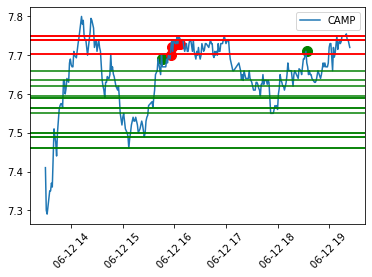

MBI analysis for run 1501 with profit -4532.26


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5484.05,-5484.05,buy,2020-06-12 16:44:06.576359,7.15,[7.07],[7.38],767,"{'avg': 7.0323, 'rsi': 67.05294528504056, 'macd': [0.0033584995826059227, 0.0071416344834052126, 0.010024242915844361, 0.011370739631678006, 0.013891547718080766], 'vwap': 7.1483, 'supports': [6.88, 6.88, 6.9, 6.9, 7.02, 7.07, 7.1], 'sell_macd': [0.0010297732466737486, 0.003559250152074256, 0.005484047089371558, 0.006393186948442597, 0.00805754025488259], 'slow macd': [0.015791201611604855, 0.016303371071439088, 0.016748508393627404, 0.016971326044479262, 0.017469054197390754], 'macd_signal': [0.0047018550318489475, 0.0051898109221602, 0.006156697320897032, 0.007199505783053227, 0.008537914170058735], 'resistances': [7.38], 'position_ratio': '4.6', 'sell_macd_signal': [0.0016368212545936826, 0.0020213070340897974, 0.0027138550451461492, 0.003449721425805439, 0.004371285191620869]}",7.41,7.02
1,-107.38,5376.67,sell,2020-06-12 17:38:33.312035,7.01,None,None,767,"{'avg': 7.0422, 'rsi': [39.445540932213504, 32.97935129493517], 'vwap': 7.02, 'reasons': 'stopped', 'movement': -0.018181818181818292, 'sell_macd': [-0.002983799307884283, -0.0028833298721266942, -0.00432603771605411, -0.005394043338387, -0.007714644559186468], 'sell_macd_signal': [-0.0036056488935404286, -0.003461185089257682, -0.0036341556146169676, -0.003986133159370974, -0.004731835439334073]}",7.41,7.02
2,-4532.26,-4424.88,buy,2020-06-12 18:33:35.106636,7.16,"[6.985, 7.06]",[7.38],618,"{'avg': 7.0429, 'rsi': 68.78100751678733, 'macd': [0.010276510150105445, 0.011190414901875556, 0.010981190249822248, 0.015478450818728895, 0.01962327376224504], 'vwap': 7.16, 'supports': [6.97, 7.0, 7.05, 7.05, 7.06, 7.07, 7.07, 7.08, 7.1], 'sell_macd': [0.006384808313346646, 0.006931371870874337, 0.006747767216079836, 0.009633948430317396, 0.01227728511114723], 'slow macd': [0.0015280778694108932, 0.002050110494757895, 0.0023671823176067974, 0.0036147287130905426, 0.0049166660746085], 'macd_signal': [0.012059337261818504, 0.011885552789829914, 0.01170468028182838, 0.012459434389208483, 0.013892202263815795], 'resistances': [7.36, 7.37, 7.38], 'position_ratio': '3.33', 'sell_macd_signal': [0.007859844888257165, 0.0076741502847805995, 0.007488873671040447, 0.007917888622895837, 0.008789767920546115]}",7.48,7.00


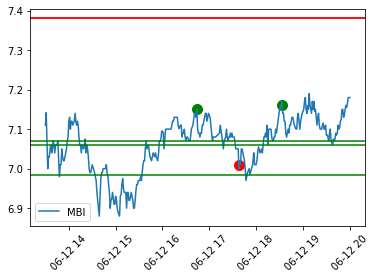

TISI analysis for run 1501 with profit 47.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6615.25,-6615.25,buy,2020-06-12 16:43:40.157910,5.63,[5.6],"[5.68, 5.71, 5.76]",1175,"{'avg': 5.5787, 'rsi': 62.4303047774818, 'macd': [0.011524809152210658, 0.01037639464452944, 0.010156110974470778, 0.011463226492522516, 0.01275554518623867], 'vwap': 5.635, 'supports': [5.48, 5.51, 5.535, 5.54, 5.55, 5.6, 5.61], 'sell_macd': [0.006940150749913165, 0.006163919598225043, 0.005998493770959179, 0.0068306490513885265, 0.007650112269237397], 'slow macd': [0.004628938926083848, 0.004713017564117905, 0.0049427708131624115, 0.005466117931434589, 0.00601883974167805], 'macd_signal': [0.011299674813521225, 0.011115018779722869, 0.01092323721867245, 0.011031235073442464, 0.011376097096001705], 'resistances': [5.68, 5.76], 'position_ratio': '1.8', 'sell_macd_signal': [0.006940890870984961, 0.006785496616432978, 0.006628096047338218, 0.00666860664814828, 0.006864907772366103]}",5.8,5.55
1,-3286.96,3328.29,sell,2020-06-12 17:52:01.524677,5.67,None,None,587,"{'avg': 5.5843, 'rsi': [64.52377443158905, 73.65853477199039], 'vwap': 5.66, 'reasons': 'scale-out', 'movement': 0.005328596802841963, 'sell_macd': [0.0019569586598100486, 0.0024080957207326392, 0.0027283571224812064, 0.0032022185118636415, 0.004568834938500466], 'sell_macd_signal': [0.0008081814611300455, 0.0011281643130505643, 0.0014482028749366928, 0.0017990060023220825, 0.002352971789557759]}",5.8,5.55
2,47.00,3333.96,sell,2020-06-12 17:54:48.121300,5.67,None,None,588,"{'avg': 5.5867, 'rsi': [78.19365301839305, 79.46291401996048], 'vwap': 5.68, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0017636684303350594, 'sell_macd': [0.0027283571224812064, 0.0032022185118636415, 0.004568834938500466, 0.006353616115899463, 0.007921580460419797], 'sell_macd_signal': [0.0014482028749366928, 0.0017990060023220825, 0.002352971789557759, 0.0031531006548261, 0.00410679661594484]}",5.8,5.55


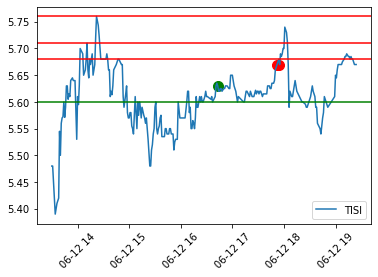

AKR analysis for run 1501 with profit -105.66


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8241.48,-8241.48,buy,2020-06-12 16:58:50.338789,14.04,"[13.58, 13.9, 13.93, 13.94]","[14.48, 14.52, 14.52, 14.53]",587,"{'avg': 13.7108, 'rsi': 66.92835012827148, 'macd': [0.012392502851431786, 0.014709768080718888, 0.01715537738479611, 0.020471391769644853, 0.023234976922791972], 'vwap': 14.0425, 'supports': [13.32, 13.4, 13.46, 13.9, 13.93, 13.94], 'sell_macd': [0.005276685307572748, 0.006913839098031005, 0.008619233751659294, 0.010875135640830536, 0.01275148600069187], 'slow macd': [0.04770282560731154, 0.04745237836876903, 0.047306001475780235, 0.04741554276459681, 0.047520457732412424], 'macd_signal': [0.017558184320372143, 0.016988501072441493, 0.017021876334912416, 0.017711779421858902, 0.018816418922045518], 'resistances': [14.48, 14.52, 14.52, 14.53], 'position_ratio': '4.14', 'sell_macd_signal': [0.008132052565461142, 0.007888409871975114, 0.00803457464791195, 0.008602686846495667, 0.009432446677334907]}",14.38,13.88
1,-105.66,8135.82,sell,2020-06-12 17:40:14.255580,13.86,None,None,587,"{'avg': 13.7424, 'rsi': [33.77245516789455, 32.374963576331865], 'vwap': 13.872, 'reasons': 'stopped', 'movement': -0.012108262108262104, 'sell_macd': [-0.004347648232045032, -0.004510513319143428, -0.007176245681570492, -0.0101992027733111, -0.01294177709449329], 'sell_macd_signal': [-0.003830801318849534, -0.003966743718908313, -0.004608644111440749, -0.005726755843814819, -0.007169760093950513]}",14.38,13.88


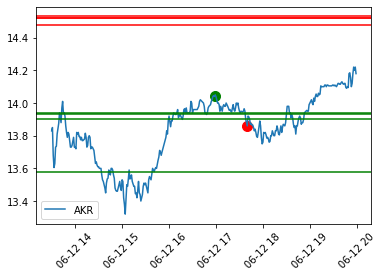

PFLT analysis for run 1501 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6187.28,-6187.28,buy,2020-06-12 16:58:12.243386,8.69,"[8.454, 8.46, 8.5, 8.54, 8.6, 8.61, 8.62]",[8.69],712,"{'avg': 8.6052, 'rsi': 60.71171729294312, 'macd': [0.013876011738828353, 0.011902791939792934, 0.013021177659183536, 0.016485198634100584, 0.019809030467619948], 'vwap': 8.6818, 'supports': [8.454, 8.46, 8.49, 8.5, 8.5, 8.54, 8.55, 8.6, 8.61, 8.62, 8.69], 'sell_macd': [0.007722124416185139, 0.006432893678306684, 0.007168130847773568, 0.009429768501282965, 0.011589099549457416], 'slow macd': [0.010659207901744239, 0.01053417203553586, 0.010963662552812892, 0.011889853288536756, 0.012882898258446573], 'macd_signal': [0.01892174563210622, 0.01751795489364356, 0.016618599446751557, 0.016591919284221362, 0.01723534152090108], 'resistances': [8.69, 8.8, 8.84], 'position_ratio': 'nan', 'sell_macd_signal': [0.011239943730679689, 0.010278533720205088, 0.009656453145718783, 0.00961111621683162, 0.01000671288335678]}",8.97,8.55
1,0.00,6187.28,sell,2020-06-12 17:16:13.177234,8.69,None,None,712,"{'avg': 8.6122, 'rsi': [58.20192036556332, 58.65458500323384], 'vwap': 8.6922, 'reasons': 'bail', 'movement': 0.00025316455696204853, 'sell_macd': [0.013382473582293386, 0.013065624729811987, 0.013168526601516461, 0.012563404337889494, 0.012037810309896813], 'sell_macd_signal': [0.01330099209721666, 0.013253918623735724, 0.013236840219291873, 0.013102153043011397, 0.01288928449638848]}",8.97,8.55


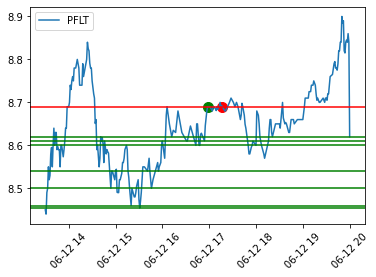

CBD analysis for run 1501 with profit -119.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8545.68,-8545.68,buy,2020-06-12 17:15:25.138958,12.87,[12.77],[13.265],664,"{'avg': 12.6993, 'rsi': 65.28248187394007, 'macd': [0.025085213515922078, 0.022889830117932775, 0.022105528821866116, 0.023233434885383986, 0.02624551587662438], 'vwap': 12.87, 'supports': [12.44, 12.57, 12.66, 12.67, 12.7, 12.7, 12.77], 'sell_macd': [0.015392320558190065, 0.013886730700001237, 0.013312417424788947, 0.013990713347679318, 0.015895999607751676], 'slow macd': [0.018047466995913197, 0.018045940201352195, 0.01825557758036389, 0.018819093493512185, 0.01978725572549145], 'macd_signal': [0.022501123882132844, 0.02257886512929283, 0.022484197867807486, 0.022634045271322786, 0.023356339392383105], 'resistances': [13.23, 13.23, 13.265, 13.4], 'position_ratio': '3.6', 'sell_macd_signal': [0.014009428597256856, 0.013984889017805733, 0.013850394699202375, 0.013878458428897764, 0.014281966664668546]}",13.17,12.72
1,-119.52,8426.16,sell,2020-06-12 17:28:41.992309,12.69,None,None,664,"{'avg': 12.7025, 'rsi': [39.831063407816124, 35.15793538721834], 'vwap': 12.71, 'reasons': 'stopped', 'movement': -0.012432012432012305, 'sell_macd': [0.014794018147487265, 0.009421052230573324, 0.005631454733878272, 0.0010469442853633382, -0.004616920275624992], 'sell_macd_signal': [0.01574358472081342, 0.014479078222765401, 0.012709553524987975, 0.010377031677063048, 0.0073782412865254395]}",13.17,12.72


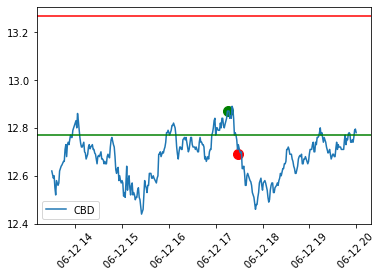

CLS analysis for run 1501 with profit -7161.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7161.0,-7161.0,buy,2020-06-12 18:47:57.699139,6.51,"[6.42, 6.45, 6.48]",[6.52],1100,"{'avg': 6.456, 'rsi': 64.37864777376848, 'macd': [0.005624670424589695, 0.005491124228525379, 0.0061216379013684374, 0.006944728238766018, 0.007909317782439196], 'vwap': 6.51, 'supports': [6.42, 6.42, 6.45, 6.48, 6.485, 6.505], 'sell_macd': [0.003381387203305941, 0.0032718451231765755, 0.00366347668251521, 0.004180806771837631, 0.004789365195051687], 'slow macd': [-0.0007309942420041793, -0.0005193675809609388, -0.00016389760199864156, 0.00024337629324389098, 0.0006976600708448188], 'macd_signal': [0.007846880076094381, 0.007375728906580581, 0.007124910705538152, 0.007088874212183726, 0.00725296292623482], 'resistances': [6.52, 6.52, 6.52, 6.55, 6.55, 6.56], 'position_ratio': '2.0', 'sell_macd_signal': [0.0050312203368259745, 0.004679345294096094, 0.004476171571779918, 0.004417098611791461, 0.004491551928443506]}",6.69,6.42


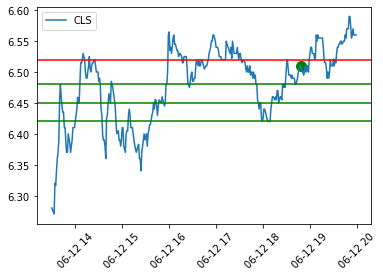

TAST analysis for run 1499 with profit 13.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2996.40,-2996.40,buy,2020-06-12 18:11:36.292970,4.54,"[4.465, 4.465, 4.52]",[4.57],660,"{'avg': 4.4244, 'rsi': 69.43826799510266, 'macd': [0.005982247311421496, 0.006660842705697334, 0.007124575932486721, 0.007797591128033687, 0.00943260199488094], 'vwap': 4.54, 'supports': [4.32, 4.435, 4.465, 4.52], 'sell_macd': [0.004117854600730553, 0.0045230955925248395, 0.004785321097915407, 0.005182051087857964, 0.006203112754204376], 'slow macd': [0.007233656363413665, 0.007351020779736039, 0.007448842226692953, 0.007605296357256819, 0.007976979591562738], 'macd_signal': [0.00071581559410571, 0.001904821016424035, 0.0029487719996365725, 0.003918535825315995, 0.005021349059228984], 'resistances': [4.57], 'position_ratio': '1.5', 'sell_macd_signal': [0.0006957174398066879, 0.0014611930703503184, 0.002126018675863336, 0.0027372251582622616, 0.0034304026774506845]}",4.84,4.39
1,-1494.90,1501.50,sell,2020-06-12 18:13:01.174302,4.55,None,None,330,"{'avg': 4.4253, 'rsi': [69.43826799510266, 75.20949439644653], 'vwap': 4.555, 'reasons': 'scale-out', 'movement': 0.004383259911894231, 'sell_macd': [0.0045230955925248395, 0.004785321097915407, 0.005182051087857964, 0.006203112754204376, 0.00795195154935513], 'sell_macd_signal': [0.0014611930703503184, 0.002126018675863336, 0.0027372251582622616, 0.0034304026774506845, 0.004334712451831573]}",4.84,4.39
2,-740.85,754.05,sell,2020-06-12 18:13:06.202395,4.57,None,None,165,"{'avg': 4.4256, 'rsi': [75.20949439644653, 77.52885526869763], 'vwap': 4.566, 'reasons': 'scale-out', 'movement': 0.004395604395604497, 'sell_macd': [0.004785321097915407, 0.005182051087857964, 0.006203112754204376, 0.00795195154935513, 0.009736086304675595], 'sell_macd_signal': [0.002126018675863336, 0.0027372251582622616, 0.0034304026774506845, 0.004334712451831573, 0.005414987222400377]}",4.84,4.39
3,13.20,754.05,sell,2020-06-12 18:13:28.237099,4.57,None,None,165,"{'avg': 4.4256, 'rsi': [75.20949439644653, 79.43393345767997], 'vwap': 4.58, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.002188183807439778, 'sell_macd': [0.004785321097915407, 0.005182051087857964, 0.006203112754204376, 0.00795195154935513, 0.010255566824156404], 'sell_macd_signal': [0.002126018675863336, 0.0027372251582622616, 0.0034304026774506845, 0.004334712451831573, 0.005518883326296539]}",4.84,4.39


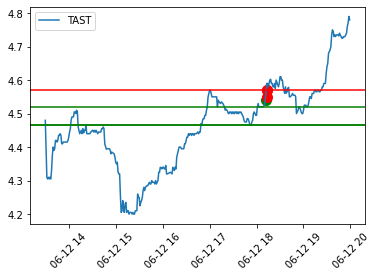

APPS analysis for run 1499 with profit 16.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4750.59,-4750.59,buy,2020-06-12 16:06:01.608347,9.37,"[9.16, 9.24, 9.28]",[9.5],507,"{'avg': 9.2253, 'rsi': 69.26129728459809, 'macd': [0.01801663720781832, 0.019696601621653542, 0.022782652354754518, 0.024940867004850986, 0.028341851508432825], 'vwap': 9.3733, 'supports': [9.1, 9.13, 9.16, 9.195, 9.23, 9.24, 9.28], 'sell_macd': [0.010690896106892112, 0.011749344382446125, 0.013720221683106715, 0.01507778553189354, 0.017238513394170596], 'slow macd': [0.011882004860888529, 0.012583798522262768, 0.013609185175894822, 0.01453080770660442, 0.015755329982628297], 'macd_signal': [0.018690768855577748, 0.018891935408792908, 0.01967007879798523, 0.020724236439358383, 0.022247759453173272], 'resistances': [9.5, 9.65], 'position_ratio': '1.44', 'sell_macd_signal': [0.011353298376266066, 0.011432507577502079, 0.011890050398623005, 0.012527597425277112, 0.013469780619055809]}",9.73,9.19
1,-5209.72,-459.13,buy,2020-06-12 16:06:01.907010,9.37,"[9.16, 9.24, 9.28]",[9.5],49,"{'avg': 9.2253, 'rsi': 69.26129728459809, 'macd': [0.01801663720781832, 0.019696601621653542, 0.022782652354754518, 0.024940867004850986, 0.028341851508432825], 'vwap': 9.3733, 'supports': [9.1, 9.13, 9.16, 9.195, 9.23, 9.24, 9.28], 'sell_macd': [0.010690896106892112, 0.011749344382446125, 0.013720221683106715, 0.01507778553189354, 0.017238513394170596], 'slow macd': [0.011882004860888529, 0.012583798522262768, 0.013609185175894822, 0.01453080770660442, 0.015755329982628297], 'macd_signal': [0.018690768855577748, 0.018891935408792908, 0.01967007879798523, 0.020724236439358383, 0.022247759453173272], 'resistances': [9.5, 9.65], 'position_ratio': '1.44', 'sell_macd_signal': [0.011353298376266066, 0.011432507577502079, 0.011890050398623005, 0.012527597425277112, 0.013469780619055809]}",9.73,9.19
2,16.68,5226.40,sell,2020-06-12 16:18:08.995891,9.40,None,None,556,"{'avg': 9.2325, 'rsi': [70.66858257878165, 70.66858257878165], 'vwap': 9.41, 'reasons': 'bail', 'movement': 0.0042689434364995655, 'sell_macd': [0.020740973548845076, 0.01941435475554698, 0.01864797186784095, 0.018847569983032386, 0.018758327345738124], 'sell_macd_signal': [0.020754310414743512, 0.020486319282904206, 0.020118649799891555, 0.019864433836519722, 0.019643212538363403]}",9.73,9.19


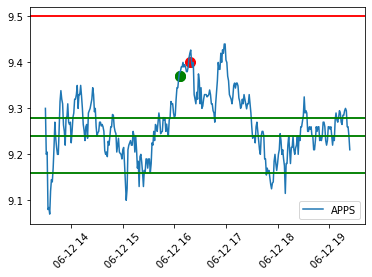

ROIC analysis for run 1499 with profit -106.65


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8204.94,-8204.94,buy,2020-06-12 17:28:31.534129,11.54,"[11.4, 11.41, 11.45, 11.475]","[11.93, 11.965, 11.98]",711,"{'avg': 11.3479, 'rsi': 66.7278742872936, 'macd': [-0.001636537064507948, -0.000416034949765276, 0.0005449400398447324, 0.002089351327546396, 0.0060675726916716854], 'vwap': 11.54, 'supports': [11.11, 11.4, 11.41, 11.41, 11.45, 11.475], 'sell_macd': [-0.0017389897855952796, -0.0008887143869902303, -0.0002146203830513116, 0.000832915469148432, 0.0034565419063277147], 'slow macd': [0.014691271242710968, 0.014499421594081241, 0.014299723981977763, 0.014253061406455103, 0.014747110653996032], 'macd_signal': [0.0007496109381783694, 0.0005164817605896403, 0.0005221734164406587, 0.0008356089986618061, 0.001882001737263782], 'resistances': [11.93, 11.965, 11.98], 'position_ratio': '6.0', 'sell_macd_signal': [-0.000374461658619977, -0.0004773122042940277, -0.0004247738400454845, -0.00017323597820670123, 0.000552719598700182]}",11.82,11.4
1,-106.65,8098.29,sell,2020-06-12 17:48:47.002567,11.39,None,None,711,"{'avg': 11.3629, 'rsi': [23.306192225528555, 21.36238622089374], 'vwap': 11.3978, 'reasons': 'stopped', 'movement': -0.012564991334488698, 'sell_macd': [0.0038963314003588323, 0.0004107055563853379, -0.0030899211474419985, -0.007595735187470254, -0.011787333982461234], 'sell_macd_signal': [0.004747169785281934, 0.0038798769395026146, 0.002485917322113692, 0.0004695868201969027, -0.001981797340334725]}",11.82,11.4


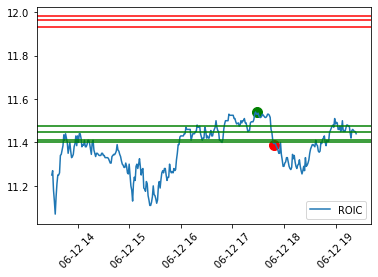

DBD analysis for run 1499 with profit -100.17


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2714.13,-2714.13,buy,2020-06-12 16:02:30.700048,5.69,"[5.0, 5.0, 5.0699, 5.31, 5.35, 5.43, 5.55, 5.56, 5.6801]","[5.765, 5.8401]",477,"{'avg': 5.5602, 'rsi': 67.99737305931124, 'macd': [0.020585981454614988, 0.023823108416355154, 0.026087830583914062, 0.03048454646352372, 0.03384511250636901], 'vwap': 5.6999, 'supports': [5.3783, 5.55, 5.56, 5.6801], 'sell_macd': [0.014858985066597441, 0.0167739778612761, 0.018048336170620516, 0.02070824737049115, 0.02268339574220235], 'slow macd': [0.004080107860183091, 0.0052066430535893105, 0.006234764168268292, 0.0077560627001371785, 0.009196080161563813], 'macd_signal': [0.005560192511906614, 0.009212775692796323, 0.012587786671019872, 0.01616713862952064, 0.019702733404890316], 'resistances': [5.765, 5.8401], 'position_ratio': '3.29', 'sell_macd_signal': [0.005531689351385682, 0.007780147053363766, 0.009833784876815115, 0.012008677375550322, 0.014143621048880728]}",6.12,5.49
1,-100.17,2613.96,sell,2020-06-12 16:48:24.010981,5.48,None,None,477,"{'avg': 5.5658, 'rsi': [32.92275335628804, 26.62263013121504], 'vwap': 5.4925, 'reasons': 'stopped', 'movement': -0.03514938488576453, 'sell_macd': [-0.007437508689917216, -0.0075088264627902745, -0.00798636204603298, -0.009813190266143579, -0.013187170823812266], 'sell_macd_signal': [-0.00899984077042556, -0.008701637908898503, -0.008558582736325399, -0.008809504242289035, -0.009685037558593682]}",6.12,5.49


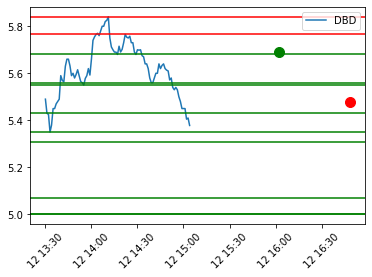

DRRX analysis for run 1499 with profit -1656.48


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1656.48,-1656.48,buy,2020-06-12 15:49:31.656504,2.32,"[2.23, 2.2744, 2.28, 2.295]",[2.325],714,"{'avg': 2.2899, 'rsi': 64.72317970435121, 'macd': [0.007026599333986194, 0.006979544442081487, 0.007716700359340578, 0.009347045304664903, 0.010916722452087857], 'vwap': 2.32, 'supports': [2.23, 2.2744, 2.275, 2.285, 2.295, 2.32], 'sell_macd': [0.005009264629473709, 0.004913995572413121, 0.005331785975061898, 0.006330950107319655, 0.007287039689503061], 'slow macd': [-0.0016309993326570904, -0.0013841910798495505, -0.0009837742249798609, -0.0003850959842939261, 0.0002462910671874319], 'macd_signal': [0.002890047700486692, 0.003707947048805651, 0.004509697710912636, 0.0054771672296630896, 0.006565078274148043], 'resistances': [2.325, 2.34, 2.35, 2.355], 'position_ratio': 'inf', 'sell_macd_signal': [0.002499762058909937, 0.0029826087616105735, 0.0034524442043008382, 0.004028145384904602, 0.0046799242458242934]}",2.6,2.18


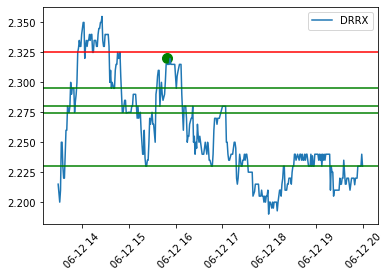

VSLR analysis for run 1498 with profit -2849.14


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3664.00,-3664.00,buy,2020-06-12 16:04:36.750061,9.16,"[8.8, 8.96]","[9.1799, 9.29]",400,"{'avg': 9.0182, 'rsi': 69.38151342860101, 'macd': [0.03498381605927037, 0.03681811424132597, 0.0370379419994471, 0.039181249308521515, 0.04280713111126033], 'vwap': 9.1599, 'supports': [8.8, 8.905, 8.96, 9.04, 9.0702, 9.09, 9.155], 'sell_macd': [0.022484439535856993, 0.023511172642011857, 0.02348640398911961, 0.024720527064928888, 0.026919577162118458], 'slow macd': [0.0025308365981260295, 0.004065751542437823, 0.005311483761825997, 0.0069289103518954676, 0.008885720804650887], 'macd_signal': [0.02430986547155088, 0.0268115152255059, 0.02885680058029414, 0.030921690325939617, 0.03329877848300376], 'resistances': [9.1799, 9.29], 'position_ratio': '3.98', 'sell_macd_signal': [0.01615384835115854, 0.017625313209329203, 0.018797531365287286, 0.019982130505215606, 0.021369619836596177]}",9.66,8.91
1,-1830.00,1834.00,sell,2020-06-12 16:06:55.463284,9.17,None,None,200,"{'avg': 9.0186, 'rsi': [67.09977020848653, 69.27604999635875], 'vwap': 9.17, 'reasons': 'scale-out', 'movement': 0.0010917030567685357, 'sell_macd': [0.02348640398911961, 0.024720527064928888, 0.026919577162118458, 0.02776403727470722, 0.029100447267961016], 'sell_macd_signal': [0.018797531365287286, 0.019982130505215606, 0.021369619836596177, 0.022648503324218385, 0.02393889211296691]}",9.66,8.91
2,-912.00,918.00,sell,2020-06-12 16:41:57.638439,9.18,None,None,100,"{'avg': 9.0264, 'rsi': [58.415017271723755, 65.87403321823176], 'vwap': 9.18, 'reasons': 'scale-out', 'movement': 0.0010905125408941971, 'sell_macd': [0.00034635924143522345, 0.0009749415457616095, 0.0014520843602277012, 0.0028439867564316046, 0.005969573211181967], 'sell_macd_signal': [0.0005948356437870513, 0.000670856824181963, 0.0008271023313911106, 0.0012304792163992096, 0.002178298015355761]}",9.66,8.91
3,-453.00,459.00,sell,2020-06-12 16:42:03.374875,9.18,None,None,50,"{'avg': 9.0264, 'rsi': [58.415017271723755, 65.87403321823176], 'vwap': 9.18, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.00034635924143522345, 0.0009749415457616095, 0.0014520843602277012, 0.0028439867564316046, 0.005969573211181967], 'sell_macd_signal': [0.0005948356437870513, 0.000670856824181963, 0.0008271023313911106, 0.0012304792163992096, 0.002178298015355761]}",9.66,8.91
4,-223.50,229.50,sell,2020-06-12 16:50:39.064658,9.18,None,None,25,"{'avg': 9.0279, 'rsi': [54.85568264709182, 61.42502235527901], 'vwap': 9.18, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.008917947125244297, 0.008460095273729706, 0.007925923762499565, 0.007474284613975257, 0.008583730931828626], 'sell_macd_signal': [0.007037230772209522, 0.007321803672513559, 0.00744262769051076, 0.007448959075203659, 0.007675913446528652]}",9.66,8.91
5,-159.24,64.26,sell,2020-06-12 16:50:40.705094,9.18,None,None,7,"{'avg': 9.0279, 'rsi': [54.85568264709182, 61.42502235527901], 'vwap': 9.18, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.008917947125244297, 0.008460095273729706, 0.007925923762499565, 0.007474284613975257, 0.008583730931828626], 'sell_macd_signal': [0.007037230772209522, 0.007321803672513559, 0.00744262769051076, 0.007448959075203659, 0.007675913446528652]}",9.66,8.91
6,-113.34,45.90,sell,2020-06-12 16:50:40.860707,9.18,None,None,5,"{'avg': 9.0279, 'rsi': [54.85568264709182, 61.42502235527901], 'vwap': 9.18, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.008917947125244297, 0.008460095273729706, 0.007925923762499565, 0.007474284613975257, 0.008583730931828626], 'sell_macd_signal': [0.007037230772209522, 0.007321803672513559, 0.00744262769051076, 0.007448959075203659, 0.007675913446528652]}",9.66,8.91
7,-58.26,55.08,sell,2020-06-12 16:50:53.841198,9.18,None,None,6,"{'avg': 9.028, 'rsi': [54.85568264709182, 62.33843237806332], 'vwap': 9.1851, 'reasons': 'scale-out', 'movement': 0.0005446623093682769, 'sell_macd': [0.008917947125244297, 0.0

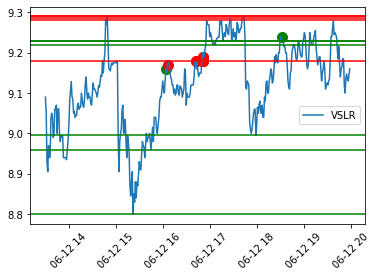

TGI analysis for run 1498 with profit -17.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2722.23,-2722.23,buy,2020-06-12 16:56:43.909847,10.43,"[9.9002, 9.92, 9.92, 9.94, 10.01, 10.135, 10.17]","[10.82, 10.85, 10.85, 10.94]",261,"{'avg': 10.0683, 'rsi': 69.2791919601022, 'macd': [0.03744691321814386, 0.0386540435503786, 0.04713650698958993, 0.052447422709889224, 0.05760614673337017], 'vwap': 10.4205, 'supports': [9.54, 10.01, 10.035, 10.05, 10.135, 10.2], 'sell_macd': [0.021729552058888046, 0.02249300322734804, 0.027990588511508818, 0.03139142654447191, 0.03467271038126718], 'slow macd': [0.036866565122394945, 0.03757013362918826, 0.03975671123799174, 0.04154491125114923, 0.0434435392340653], 'macd_signal': [0.035651684253610594, 0.036252156112964194, 0.03842902628828934, 0.041232705572609316, 0.044507393804761486], 'resistances': [10.85, 10.94], 'position_ratio': '1.83', 'sell_macd_signal': [0.020668473002586236, 0.021033379047538596, 0.02242482094033264, 0.024218142061160495, 0.026309055725181833]}",11.11,10.09
1,-3055.99,-333.76,buy,2020-06-12 16:56:44.386170,10.43,"[9.9002, 9.92, 9.92, 9.94, 10.01, 10.135, 10.17]","[10.82, 10.85, 10.85, 10.94]",32,"{'avg': 10.0683, 'rsi': 69.2791919601022, 'macd': [0.03744691321814386, 0.0386540435503786, 0.04713650698958993, 0.052447422709889224, 0.05760614673337017], 'vwap': 10.4205, 'supports': [9.54, 10.01, 10.035, 10.05, 10.135, 10.2], 'sell_macd': [0.021729552058888046, 0.02249300322734804, 0.027990588511508818, 0.03139142654447191, 0.03467271038126718], 'slow macd': [0.036866565122394945, 0.03757013362918826, 0.03975671123799174, 0.04154491125114923, 0.0434435392340653], 'macd_signal': [0.035651684253610594, 0.036252156112964194, 0.03842902628828934, 0.041232705572609316, 0.044507393804761486], 'resistances': [10.85, 10.94], 'position_ratio': '1.83', 'sell_macd_signal': [0.020668473002586236, 0.021033379047538596, 0.02242482094033264, 0.024218142061160495, 0.026309055725181833]}",11.11,10.09
2,-1502.55,1553.44,sell,2020-06-12 17:16:52.826294,10.64,None,None,146,"{'avg': 10.1071, 'rsi': [74.37996270701409, 76.49310626353835], 'vwap': 10.6369, 'reasons': 'scale-out', 'movement': 0.020134228187919545, 'sell_macd': [0.02968123543791279, 0.03228629068384237, 0.03607871956789488, 0.038721148314326825, 0.041835753203567805], 'sell_macd_signal': [0.031718118085038285, 0.031831752604799105, 0.03268114599741826, 0.033889146460799977, 0.03547846780935354]}",11.11,10.09
3,-169.35,1333.20,sell,2020-06-12 17:48:05.021742,10.10,None,None,132,"{'avg': 10.1426, 'rsi': [30.507289078560646, 26.148317503195024], 'vwap': 10.0945, 'reasons': 'stopped', 'movement': -0.05168233082706775, 'sell_macd': [-0.019603276263939762, -0.021387748507949667, -0.026656327548632675, -0.03405189137840381, -0.04404256590318134], 'sell_macd_signal': [-0.015341105914882183, -0.01655043443349568, -0.01857161305652308, -0.021667668720899223, -0.026142648157355647]}",11.11,10.09
4,-17.85,151.50,sell,2020-06-12 17:48:05.224128,10.10,None,None,15,"{'avg': 10.1426, 'rsi': [30.507289078560646, 26.148317503195024], 'vwap': 10.0945, 'reasons': 'stopped', 'movement': -0.05168233082706775, 'sell_macd': [-0.019603276263939762, -0.021387748507949667, -0.026656327548632675, -0.03405189137840381, -0.04404256590318134], 'sell_macd_signal': [-0.015341105914882183, -0.01655043443349568, -0.01857161305652308, -0.021667668720899223, -0.026142648157355647]}",11.11,10.09


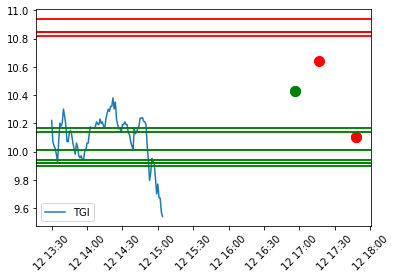

PGEN analysis for run 1498 with profit -48.38


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-497.96,-497.96,buy,2020-06-12 15:40:34.287899,4.22,"[3.88, 3.9101]",[4.2201],118,"{'avg': 3.9988, 'rsi': 65.77536293705656, 'macd': [0.047169467583540126, 0.05413309370021935, 0.05897202477510799, 0.060495722628366444, 0.06100009305324594], 'vwap': 4.2247, 'supports': [3.68, 3.85, 3.855, 4.11], 'sell_macd': [0.027418802035266587, 0.031896661739016174, 0.034971660706365704, 0.035874625347075195, 0.03611232993273106], 'slow macd': [0.03700589171115798, 0.039268122597365895, 0.041286643500515474, 0.04275784303036101, 0.044043008462609556], 'macd_signal': [0.05263540587221139, 0.05293494343781298, 0.05414235970527198, 0.055413032289890876, 0.05653044444256189], 'resistances': [4.5], 'position_ratio': '2.25', 'sell_macd_signal': [0.031423010618622176, 0.031517740842700974, 0.03220852481543392, 0.032941744921762176, 0.03357586192395595]}",5.08,3.81
1,-269.36,228.60,sell,2020-06-12 18:00:13.069454,3.81,None,None,60,"{'avg': 4.029, 'rsi': [35.59930624279936, 27.71883228307752], 'vwap': 3.81, 'reasons': 'stopped', 'movement': -0.09715639810426534, 'sell_macd': [-0.01439300522660103, -0.013935261411187394, -0.013917081017213562, -0.013981913424283121, -0.01618851122947662], 'sell_macd_signal': [-0.01422505735619858, -0.014167098167196343, -0.014117094737199787, -0.014090058474616455, -0.014509749025588489]}",5.08,3.81
2,-48.38,220.98,sell,2020-06-12 18:00:13.314702,3.81,None,None,58,"{'avg': 4.029, 'rsi': [35.59930624279936, 27.71883228307752], 'vwap': 3.81, 'reasons': 'stopped', 'movement': -0.09715639810426534, 'sell_macd': [-0.01439300522660103, -0.013935261411187394, -0.013917081017213562, -0.013981913424283121, -0.01618851122947662], 'sell_macd_signal': [-0.01422505735619858, -0.014167098167196343, -0.014117094737199787, -0.014090058474616455, -0.014509749025588489]}",5.08,3.81


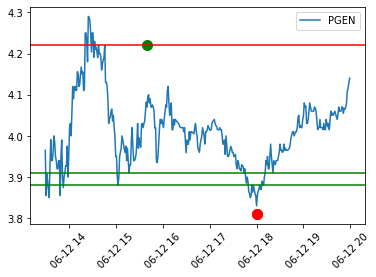

DRH analysis for run 1498 with profit 36.24


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5907.12,-5907.12,buy,2020-06-12 16:46:57.621997,6.52,"[6.46, 6.465]","[6.76, 6.815, 6.815]",906,"{'avg': 6.3281, 'rsi': 66.56722655364516, 'macd': [0.01651206057479726, 0.01636443096671769, 0.016461137900938283, 0.016748174525743842, 0.0175799191802124], 'vwap': 6.52, 'supports': [6.16, 6.1601, 6.165, 6.46, 6.465], 'sell_macd': [0.008498433166926667, 0.008472529651064598, 0.008602052500378932, 0.008851004688152031, 0.009449525812544657], 'slow macd': [0.03105169053751311, 0.030890143918386848, 0.030772079405678276, 0.030694208649435062, 0.03073340999101326], 'macd_signal': [0.01788898994895207, 0.017584078152505195, 0.017359490102191812, 0.017237226986902218, 0.017305765425564255], 'resistances': [6.755, 6.76, 6.815, 6.815], 'position_ratio': '4.27', 'sell_macd_signal': [0.009093476156805088, 0.00896928685565699, 0.008895839984601379, 0.008886872925311508, 0.008999403502758139]}",6.74,6.41
1,36.24,5943.36,sell,2020-06-12 17:00:55.260978,6.56,None,None,906,"{'avg': 6.3337, 'rsi': [77.40917485400264, 79.96392424988011], 'vwap': 6.5621, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.007668711656441827, 'sell_macd': [0.011022656537551967, 0.011236022956857994, 0.011775840647787028, 0.012043544814123841, 0.012615216309787236], 'sell_macd_signal': [0.010589906687517085, 0.010719129941385266, 0.010930472082665618, 0.011153086628957263, 0.011445512565123257]}",6.74,6.41


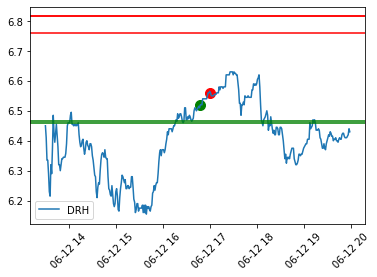

UNFI analysis for run 1498 with profit -104.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7038.3,-7038.3,buy,2020-06-12 16:08:25.348080,16.18,"[15.7, 15.83, 15.8334, 16.01]","[16.45, 16.515, 16.53]",435,"{'avg': 16.0683, 'rsi': 66.39036770929695, 'macd': [0.026389057844347974, 0.03176376072096332, 0.03720817168445478, 0.04183945467084271, 0.04579684784056681], 'vwap': 16.1763, 'supports': [15.7, 15.83, 15.8334, 15.88, 16.01], 'sell_macd': [0.01650906063863289, 0.019880210534683584, 0.023287857070116047, 0.02615501207084492, 0.028574158667893812], 'slow macd': [-0.0037636480692633256, -0.0016181125616299141, 0.0006783087311781344, 0.002948341581969771, 0.005193664342201032], 'macd_signal': [0.028918028687686864, 0.029487175094342157, 0.03103137441236468, 0.03319299046406029, 0.03571376193936159], 'resistances': [16.45, 16.515, 16.53], 'position_ratio': '1.59', 'sell_macd_signal': [0.018969981043798517, 0.01915202694197553, 0.019979192967603636, 0.02121435678825189, 0.022686317164180275]}",16.64,15.95
1,-104.4,6933.9,sell,2020-06-12 16:44:24.304600,15.94,None,None,435,"{'avg': 16.0697, 'rsi': [36.76668150966339, 35.216341734257895], 'vwap': 15.9448, 'reasons': 'stopped', 'movement': -0.014833127317676156, 'sell_macd': [0.0008384255987756717, 0.00257281206753035, -0.001303936295354191, -0.007944208574286904, -0.014054236212750482], 'sell_macd_signal': [0.004707969220643281, 0.004280937790020695, 0.0031639629729457177, 0.0009423286634991932, -0.002056984311750742]}",16.64,15.95


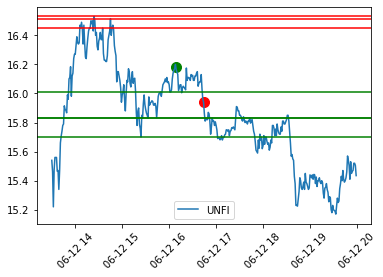

BLDP analysis for run 1498 with profit -99.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6345.08,-6345.08,buy,2020-06-12 16:23:10.751993,13.33,[13.21],[13.33],476,"{'avg': 13.2625, 'rsi': 68.02008257767334, 'macd': [0.01241415267188195, 0.012066371254386254, 0.014057524032653035, 0.017020877075083263, 0.022355459919435106], 'vwap': 13.34, 'supports': [12.96, 13.0201, 13.04, 13.05, 13.21], 'sell_macd': [0.0061554742837870435, 0.005958789220061433, 0.007291777622091544, 0.00925395329091927, 0.012751051821293657], 'slow macd': [0.008198781215249085, 0.00846719734257384, 0.009182014103711111, 0.010138457650677779, 0.011645144084491577], 'macd_signal': [0.02409095187927034, 0.021686035754293523, 0.020160333409965425, 0.019532442142988993, 0.020097045698278214], 'resistances': [13.63], 'position_ratio': '2.23', 'sell_macd_signal': [0.014044170246007789, 0.012427094040818518, 0.011400030757073123, 0.010970815263842353, 0.011326862575332613]}",13.76,13.13
1,-99.96,6245.12,sell,2020-06-12 17:05:33.263217,13.12,None,None,476,"{'avg': 13.2608, 'rsi': [40.00901483064456, 37.389728487436635], 'vwap': 13.1241, 'reasons': 'stopped', 'movement': -0.0153788447111778, 'sell_macd': [-0.008626059106619621, -0.009807912550744646, -0.010081981305246401, -0.010684087071025417, -0.011793726796684112], 'sell_macd_signal': [-0.01020742474538571, -0.010127522306457496, -0.010118414106215277, -0.010231548699177305, -0.010543984318678666]}",13.76,13.13


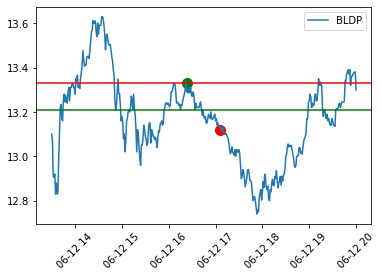

NNVC analysis for run 1502 with profit 54.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5519.25,-5519.25,buy,2020-06-12 18:30:28.943215,6.69,"[6.54, 6.6, 6.6, 6.62, 6.625, 6.635, 6.65, 6.67, 6.67, 6.6779]",[6.7],825,"{'avg': 6.564, 'rsi': 60.440037796862036, 'macd': [-0.002262371636283511, -0.0015922932749656837, 3.834139457481456e-06, 0.0024508988186831004, 0.005137905062309045], 'vwap': 6.69, 'supports': [6.42, 6.48, 6.53, 6.54, 6.547, 6.6, 6.6, 6.62, 6.625, 6.635, 6.65, 6.67, 6.6779], 'sell_macd': [-0.0023084300791982315, -0.001802386853618998, -0.0006989455498747077, 0.0009491768368077302, 0.002740581594784075], 'slow macd': [0.01247486601148573, 0.012232859061446888, 0.012201755731464203, 0.012393528708187773, 0.012710080289398462], 'macd_signal': [0.000886129308822246, 0.00039044479206466005, 0.0003131226615432243, 0.0007406778929711996, 0.0016201233268387685], 'resistances': [6.7], 'position_ratio': '0.83', 'sell_macd_signal': [-0.0004926580157647122, -0.0007546037833355693, -0.000743472136643397, -0.00040494234195317155, 0.00022416244539427786]}",6.93,6.57
1,-2738.25,2781.00,sell,2020-06-12 18:34:37.837958,6.75,None,None,412,"{'avg': 6.567, 'rsi': [62.46215571207407, 71.044730422621], 'vwap': 6.7109, 'reasons': 'scale-out', 'movement': 0.008968609865470793, 'sell_macd': [-0.0006989455498747077, 0.0009491768368077302, 0.003260062114263995, 0.005018413471836958, 0.00892078578329869], 'sell_macd_signal': [-0.000743472136643397, -0.00040494234195317155, 0.0003280585492902618, 0.001266129533799601, 0.0027970607836994192]}",6.93,6.57
2,-1347.75,1390.50,sell,2020-06-12 18:34:48.082633,6.75,None,None,206,"{'avg': 6.5712, 'rsi': [67.30733943631083, 71.98102134578431], 'vwap': 6.755, 'reasons': 'scale-out', 'movement': 0.000740740740740725, 'sell_macd': [0.0009491768368077302, 0.003260062114263995, 0.005018413471836958, 0.007622084484597558, 0.011110372488247755], 'sell_macd_signal': [-0.00040494234195317155, 0.0003280585492902618, 0.001266129533799601, 0.0025373205239591925, 0.004251930916816905]}",6.93,6.57
3,-650.44,697.31,sell,2020-06-12 18:36:21.165146,6.77,None,None,103,"{'avg': 6.5718, 'rsi': [71.98102134578431, 73.9836907359257], 'vwap': 6.77, 'reasons': 'scale-out', 'movement': 0.0029629629629629, 'sell_macd': [0.003260062114263995, 0.005018413471836958, 0.007622084484597558, 0.011110372488247755, 0.01446344921202325], 'sell_macd_signal': [0.0003280585492902618, 0.001266129533799601, 0.0025373205239591925, 0.004251930916816905, 0.006294234575858174]}",6.93,6.57
4,-609.76,40.68,sell,2020-06-12 18:38:10.477186,6.78,None,None,6,"{'avg': 6.5727, 'rsi': [76.2473343436523, 75.01721838185652], 'vwap': 6.7833, 'reasons': 'scale-out', 'movement': 0.002437223042836134, 'sell_macd': [0.005018413471836958, 0.007622084484597558, 0.011110372488247755, 0.015502410250983978, 0.018541629153753902], 'sell_macd_signal': [0.001266129533799601, 0.0025373205239591925, 0.004251930916816905, 0.006502026783650319, 0.008909947257671035]}",6.93,6.57
5,-297.88,311.88,sell,2020-06-12 18:38:10.751256,6.78,None,None,46,"{'avg': 6.5727, 'rsi': [76.2473343436523, 75.01721838185652], 'vwap': 6.7833, 'reasons': 'scale-out', 'movement': 0.002437223042836134, 'sell_macd': [0.005018413471836958, 0.007622084484597558, 0.011110372488247755, 0.015502410250983978, 0.018541629153753902], 'sell_macd_signal': [0.001266129533799601, 0.0025373205239591925, 0.004251930916816905, 0.006502026783650319, 0.008909947257671035]}",6.93,6.57
6,-121.60,176.28,sell,2020-06-12 18:38:15.232658,6.78,None,None,26,"{'avg': 6.5739, 'rsi': [72.83495796609085, 72.83495796609084], 'vwap': 6.781, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.007622084484597558, 0.011110372488247755, 0.015502410250983978, 0.018203966816090933, 0.020072660674406606], 'sell_macd_signal': [0.0025373205239591925, 0.004251930916816905, 0.006502026783650319, 0.008842414790138442, 0.011088463966992075]}",6.93,6.57
7,-94.48,27.12,sell,2020-06-12 18:38:15.839306,6.78,None,None,4,"{'avg': 6.5741, 

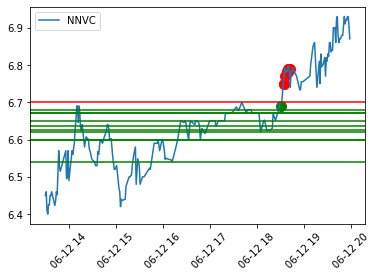

CNCE analysis for run 1502 with profit -4559.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4559.28,-4559.28,buy,2020-06-12 18:31:54.120982,9.68,"[9.52, 9.525, 9.53, 9.53, 9.54, 9.54, 9.55]","[9.68, 9.6884]",471,"{'avg': 9.5495, 'rsi': 67.10179532018964, 'macd': [0.0007012519646369952, 0.0033704022700753455, 0.004625486956443936, 0.00874698650324035, 0.01666272561821458], 'vwap': 9.6972, 'supports': [9.47, 9.48, 9.52, 9.53, 9.53, 9.53, 9.53, 9.54, 9.54, 9.54, 9.55, 9.56, 9.6], 'sell_macd': [0.0005291294807712177, 0.0022483320635515724, 0.003039290802552941, 0.005694073056288218, 0.010805668668856683], 'slow macd': [0.0008342081210628294, 0.0013566377827984866, 0.001675184004518826, 0.002605321597544119, 0.004416527241351886], 'macd_signal': [0.003155956632469793, 0.003198845759990903, 0.0034841739992815097, 0.0045367365000732775, 0.006961934323701538], 'resistances': [9.86, 9.86, 9.91], 'position_ratio': '1.89', 'sell_macd_signal': [0.002292203627057088, 0.002283429314355985, 0.002434601611995376, 0.0030864959008539443, 0.004630330454454492]}",10.11,9.48


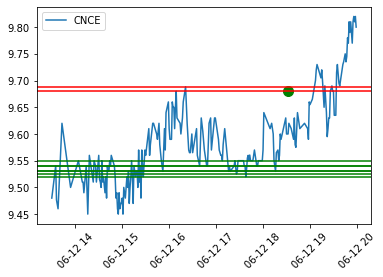

NMIH analysis for run 1500 with profit 21.53


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2953.02,-2953.02,buy,2020-06-12 15:44:04.682826,16.59,[16.12],[16.6201],178,"{'avg': 16.3907, 'rsi': 69.99977403546505, 'macd': [0.036320896039889305, 0.04368800579596055, 0.0545461344561744, 0.06322932774316925, 0.07090727886268411], 'vwap': 16.61, 'supports': [16.12, 16.225, 16.23, 16.335, 16.57], 'sell_macd': [0.025466534480660385, 0.03000111846735365, 0.03678129925611273, 0.042106358321948534, 0.04674788021322129], 'slow macd': [-0.0032293945700843096, -0.0005491852158883148, 0.003037123646514317, 0.006491721086661073, 0.009979550684992233], 'macd_signal': [0.002729398661389607, 0.010921120088303796, 0.01964612296187792, 0.028362763918136184, 0.03687166690704577], 'resistances': [16.71, 16.74], 'position_ratio': '2.5', 'sell_macd_signal': [0.003967123906874878, 0.009173922818970632, 0.014695398106399051, 0.02017759014950895, 0.02549164816225142]}",17.73,16.05
1,-1467.61,1485.41,sell,2020-06-12 15:59:40.933730,16.69,None,None,89,"{'avg': 16.4, 'rsi': [67.44660094337596, 66.26476281012395], 'vwap': 16.69, 'reasons': 'scale-out', 'movement': 0.006027727546714975, 'sell_macd': [0.028743639889651007, 0.030888544119612504, 0.03137952736217997, 0.03680913083220716, 0.04004246949934398], 'sell_macd_signal': [0.03338480943838344, 0.032885556374629255, 0.032584350572139396, 0.03342930662415295, 0.03475193919919116]}",17.73,16.05
2,-731.93,735.68,sell,2020-06-12 16:00:55.186190,16.72,None,None,44,"{'avg': 16.4014, 'rsi': [66.26476281012395, 68.07223800746496], 'vwap': 16.72, 'reasons': 'scale-out', 'movement': 0.0017974835230675603, 'sell_macd': [0.030888544119612504, 0.03137952736217997, 0.03680913083220716, 0.04004246949934398, 0.043600363662054775], 'sell_macd_signal': [0.032885556374629255, 0.032584350572139396, 0.03342930662415295, 0.03475193919919116, 0.036521624091763884]}",17.73,16.05
3,-364.09,367.84,sell,2020-06-12 16:01:09.847611,16.72,None,None,22,"{'avg': 16.4016, 'rsi': [68.07223800746496, 68.0906495944894], 'vwap': 16.7203, 'reasons': 'scale-out', 'movement': 1.7942583732228084e-05, 'sell_macd': [0.03137952736217997, 0.03680913083220716, 0.04004246949934398, 0.043600363662054775, 0.045822094650372236], 'sell_macd_signal': [0.032584350572139396, 0.03342930662415295, 0.03475193919919116, 0.036521624091763884, 0.03838171820348556]}",17.73,16.05
4,-180.06,184.03,sell,2020-06-12 16:04:40.242301,16.73,None,None,11,"{'avg': 16.406, 'rsi': [64.0898186699422, 66.21817689358093], 'vwap': 16.7206, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.04004246949934398, 0.043600363662054775, 0.04580651023478666, 0.0453722541845174, 0.046003064350742306], 'sell_macd_signal': [0.03475193919919116, 0.036521624091763884, 0.03837860132036844, 0.03977733189319823, 0.041022478384707045]}",17.73,16.05
5,-79.44,100.62,sell,2020-06-12 16:04:45.039465,16.77,None,None,6,"{'avg': 16.4069, 'rsi': [67.50224832701367, 68.7802182900034], 'vwap': 16.7713, 'reasons': 'scale-out', 'movement': 0.0017931858936043716, 'sell_macd': [0.043600363662054775, 0.04580651023478666, 0.0453722541845174, 0.04704202538970392, 0.048771171453619644], 'sell_macd_signal': [0.036521624091763884, 0.03837860132036844, 0.03977733189319823, 0.04123027059249937, 0.04273845076472342]}",17.73,16.05
6,-29.04,50.40,sell,2020-06-12 16:06:04.945322,16.80,None,None,3,"{'avg': 16.4087, 'rsi': [68.7802182900034, 71.21804224931783], 'vwap': 16.7995, 'reasons': 'scale-out', 'movement': 0.0017889087656530196, 'sell_macd': [0.04580651023478666, 0.0453722541845174, 0.04704202538970392, 0.048771171453619644, 0.05156308823779199], 'sell_macd_signal': [0.03837860132036844, 0.03977733189319823, 0.04123027059249937, 0.04273845076472342, 0.04450337825933713]}",17.73,16.05
7,-12.18,16.86,sell,2020-06-12 16:06:31.288223,16.86,None,None,1,"{'avg': 16.4097, 'rsi': [71.76914990434786, 72.88730854207759], 'vwap': 16.8257, 'reasons': 'scale-out', 'movement': 0.001785714285714142, 'sell_macd': [0.0453722541

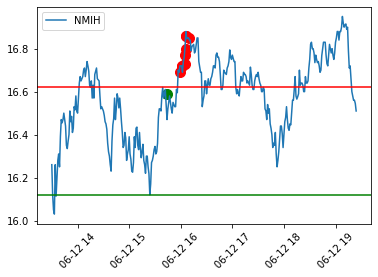

NOVA analysis for run 1500 with profit -4615.62


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4366.20,-4366.20,buy,2020-06-12 15:54:42.571958,15.32,"[14.515, 14.58]","[15.58, 15.68]",285,"{'avg': 14.8739, 'rsi': 67.97711298410493, 'macd': [0.09650152334451967, 0.09842506264035578, 0.09774151009276011, 0.10114964971965357, 0.10506030441628589], 'vwap': 15.3118, 'supports': [14.515, 14.55, 14.58, 14.9, 14.94, 14.96, 15.02], 'sell_macd': [0.06021192633921757, 0.0611032684158932, 0.06030816784686266, 0.06219889249636168, 0.064422848164849], 'slow macd': [0.040539948379793245, 0.04333740001341013, 0.04562751860953007, 0.04867552053485369, 0.051881738187006476], 'macd_signal': [0.08159358588178092, 0.08495988123349589, 0.08751620700534873, 0.0902428955482097, 0.09320637732182493], 'resistances': [15.58, 15.68], 'position_ratio': '0.87', 'sell_macd_signal': [0.05198648614295167, 0.05380984259753997, 0.05510950764740451, 0.05652738461719594, 0.05810647732672655]}",16.02,14.97
1,17.10,4383.30,sell,2020-06-12 16:03:06.969506,15.38,None,None,285,"{'avg': 14.898, 'rsi': [59.041979585289916, 60.128221468249144], 'vwap': 15.4025, 'reasons': 'bail', 'movement': 0.005385117493472557, 'sell_macd': [0.08504952232661367, 0.08470989077897961, 0.0869762831992773, 0.07987248140731218, 0.07441662960308726], 'sell_macd_signal': [0.06982978565691651, 0.07280580668132913, 0.07563990198491877, 0.07648641786939744, 0.07607246021613541]}",16.02,14.97
2,-4615.62,-4632.72,buy,2020-06-12 18:33:51.602677,15.92,"[15.407, 15.41, 15.49, 15.6, 15.63]","[16.5, 16.5]",291,"{'avg': 15.1134, 'rsi': 69.41796502862822, 'macd': [0.044699638956196, 0.04953773757328328, 0.05116829646047805, 0.059042172552036476, 0.07012236410465889], 'vwap': 15.92, 'supports': [15.3601, 15.407, 15.41, 15.41, 15.49, 15.595, 15.6, 15.63], 'sell_macd': [0.02765089531645515, 0.0306478562004191, 0.03154616525025489, 0.036511780545577466, 0.043543275833549444], 'slow macd': [0.023313348205972417, 0.02528234113416694, 0.02673356998792009, 0.029465414575101434, 0.0330512253455133], 'macd_signal': [0.03912037328527486, 0.041203846142876546, 0.043196736206396844, 0.04636582347552477, 0.0511171316013516], 'resistances': [16.5], 'position_ratio': '2.0', 'sell_macd_signal': [0.024693109787166136, 0.02588405906981673, 0.02701648030590436, 0.028915540353838982, 0.03184108744978108]}",16.60,15.58


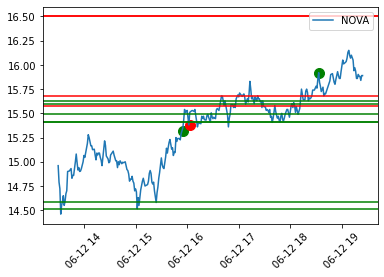

OPRA analysis for run 1500 with profit -105.66


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4161.83,-4161.83,buy,2020-06-12 16:17:04.491143,7.09,"[6.53, 6.53, 6.615, 6.63, 6.83, 7.03]","[7.23, 7.31]",587,"{'avg': 7.0526, 'rsi': 67.04931586224127, 'macd': [0.004001094900533353, 0.007813029073357569, 0.010710549817611437, 0.011662048408492609, 0.016662088063359448], 'vwap': 7.084, 'supports': [6.53, 6.83, 6.975, 6.98, 7.03], 'sell_macd': [0.0027510221849755823, 0.00520822393629139, 0.0070552873277547334, 0.007623709615547369, 0.010824769714924187], 'slow macd': [0.009540078171908384, 0.010141285296571212, 0.01067819551354976, 0.010915187767533752, 0.011995419045161881], 'macd_signal': [-9.818809193412256e-05, 0.0014840553411242159, 0.00332935423642166, 0.004995893070835851, 0.00732913206934057], 'resistances': [7.23, 7.31], 'position_ratio': '1.86', 'sell_macd_signal': [0.00013327999852905212, 0.0011482687860815198, 0.0023296724944161626, 0.003388479918642404, 0.00487573787789876]}",7.44,6.93
1,-105.66,4056.17,sell,2020-06-12 17:55:39.164057,6.91,None,None,587,"{'avg': 7.0464, 'rsi': [33.15794493303086, 25.069229654980646], 'vwap': 6.911, 'reasons': 'stopped', 'movement': -0.02679830747531728, 'sell_macd': [-0.004572177884863748, -0.005514329486099534, -0.006696339441789156, -0.008829122011913881, -0.013233509443025149], 'sell_macd_signal': [-0.0011092915573905795, -0.0019902991431323706, -0.002931507202863728, -0.004111030164673759, -0.005935526020344037]}",7.44,6.93


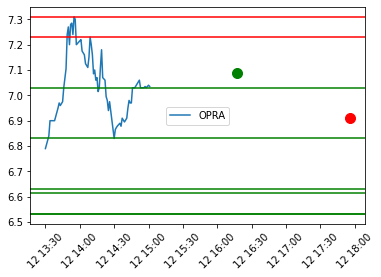

MMYT analysis for run 1500 with profit -116.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10248.84,-10248.84,buy,2020-06-12 16:58:48.680722,17.64,"[17.5158, 17.53]",[17.65],581,"{'avg': 17.3962, 'rsi': 65.56208999066133, 'macd': [-0.0006821059144890285, 0.0021467235997576495, 0.005934020528584938, 0.01122681418474869, 0.015365307058555544], 'vwap': 17.651, 'supports': [17.23, 17.31, 17.32, 17.485, 17.5, 17.5158, 17.53, 17.58], 'sell_macd': [-0.0007631465520141489, 0.0011227881400301953, 0.0036167270151317155, 0.0070715270864418756, 0.00974966315387249], 'slow macd': [0.020732787532189434, 0.0206874772216743, 0.020932575608966886, 0.02160440331257618, 0.02221194346961397], 'macd_signal': [-0.004148749167890518, -0.0028896546143608844, -0.00112491958577172, 0.001345427168332362, 0.0041494031463769985], 'resistances': [17.89, 17.91], 'position_ratio': '3.34', 'sell_macd_signal': [-0.0033694003598312, -0.0024709626598589207, -0.0012534247248607933, 0.00041156563739974043, 0.002279185140694291]}",17.99,17.48
1,-116.20,10132.64,sell,2020-06-12 18:19:51.029301,17.44,None,None,581,"{'avg': 17.4396, 'rsi': [54.30482608881106, 39.411308695901134], 'vwap': 17.48, 'reasons': 'stopped', 'movement': -0.009070294784580506, 'sell_macd': [-2.733114008890425e-05, 0.001519082101584246, 0.001405649795074737, 0.0023379668316287905, -0.0013814999818571039], 'sell_macd_signal': [-0.004053664908384834, -0.0029391155063910176, -0.0020701624460978665, -0.001188536590552535, -0.001227129268813449]}",17.99,17.48


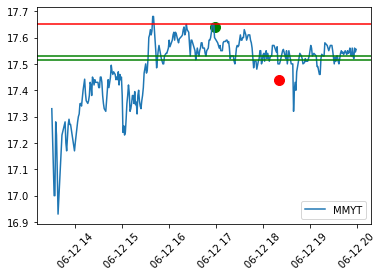

QTNT analysis for run 1500 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3223.35,-3223.35,buy,2020-06-12 15:58:17.816547,7.41,[7.26],"[7.4369, 7.47, 7.5]",435,"{'avg': 7.2595, 'rsi': 69.14114413684506, 'macd': [0.0226493472689393, 0.025373362380667785, 0.026787637896914518, 0.035966484664379905, 0.04195029356009261], 'vwap': 7.41, 'supports': [7.06, 7.095, 7.14, 7.185, 7.23, 7.25, 7.4], 'sell_macd': [0.013935579478639326, 0.01562688127858447, 0.016461312794404215, 0.02235228134186862, 0.02613287655623253], 'slow macd': [0.004581504608750286, 0.005845574594612657, 0.006912844782173799, 0.009563039633214032, 0.011826072897393125], 'macd_signal': [0.02257479314407454, 0.02313450699139319, 0.023865133172497454, 0.026285403470873943, 0.029418381488717678], 'resistances': [7.4369, 7.47, 7.5], 'position_ratio': '2.69', 'sell_macd_signal': [0.014355042934866983, 0.01460941060361048, 0.014979791041769228, 0.016454289101789105, 0.01839000659267779]}",7.87,7.18
1,0.00,3223.35,sell,2020-06-12 16:10:12.058361,7.41,None,None,435,"{'avg': 7.2658, 'rsi': [65.79699668526484, 65.79699668526486], 'vwap': 7.42, 'reasons': 'bail', 'movement': 0.00134952766531711, 'sell_macd': [0.030391470497767692, 0.03025783031170981, 0.029760736266577048, 0.028986887188985122, 0.02800743482736845], 'sell_macd_signal': [0.026982573633350868, 0.027637624969022657, 0.028062247228533534, 0.028247175220623852, 0.02819922714197277]}",7.87,7.18


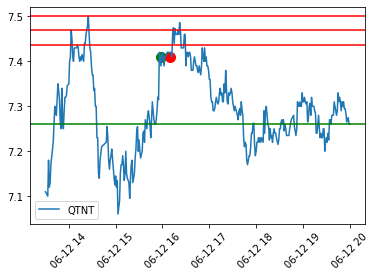

DSS analysis for run 1500 with profit -3245.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3245.13,-3245.13,buy,2020-06-12 15:57:25.869291,9.09,"[8.75, 8.8101]","[9.09, 9.31, 9.36, 9.65]",357,"{'avg': 9.123, 'rsi': 59.22338813728069, 'macd': [-0.03791310952755467, -0.020653787161371895, -0.006896155254404235, 0.003331005416345789, 0.01272572097985325], 'vwap': 9.0982, 'supports': [7.92, 7.95, 8.1701, 8.36, 8.3601, 8.3601, 8.75, 8.87], 'sell_macd': [-0.02069188774470021, -0.00945872262279046, -0.0005827663898383406, 0.005930741926615468, 0.011853855654676337], 'slow macd': [0.007655016792464053, 0.009249672418642163, 0.010702013044856074, 0.01189474704275284, 0.013257762612919777], 'macd_signal': [-0.05473489548743733, -0.04791867382222424, -0.03971417010866024, -0.031105135003659034, -0.022338963806956574], 'resistances': [9.31, 9.36, 9.65], 'position_ratio': '0.91', 'sell_macd_signal': [-0.032367018252067684, -0.027785359126212238, -0.022344840578937458, -0.016689724077826873, -0.010981008131326232]}",9.66,8.82


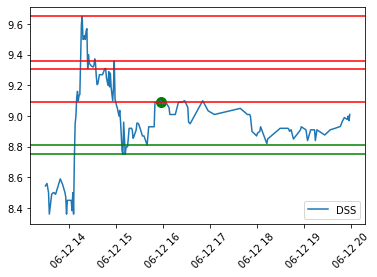

SSL analysis for run 1497 with profit -4203.25


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2198.68,-2198.68,buy,2020-06-12 15:41:28.509297,8.36,"[8.0309, 8.095]","[8.4558, 8.4574]",263,"{'avg': 8.2629, 'rsi': 69.41723049748235, 'macd': [0.01811693262721903, 0.02496112646778137, 0.03362069569935855, 0.039232373066553805, 0.0455750562110353], 'vwap': 8.36, 'supports': [8.0309, 8.095, 8.2, 8.2026, 8.33], 'sell_macd': [0.013370466583122464, 0.017657536861774403, 0.02310125997680501, 0.02652882006674062, 0.030413557538549796], 'slow macd': [-0.001577024740830879, 0.0003202859499840116, 0.002783472977478496, 0.004886895391855717, 0.007294103466190194], 'macd_signal': [-0.0031157235536911658, 0.0024996464506033414, 0.008723856300354382, 0.014825559653594268, 0.020975458965082475], 'resistances': [8.4558, 8.4574], 'position_ratio': '3.19', 'sell_macd_signal': [-0.00018967086102794194, 0.0033797706835325273, 0.007324068542187024, 0.011165018847097743, 0.015014726585388154]}",9.12,7.98
1,-1095.66,1103.02,sell,2020-06-12 15:57:33.914831,8.42,None,None,131,"{'avg': 8.2655, 'rsi': [63.031031312744254, 65.10122243727001], 'vwap': 8.4024, 'reasons': 'scale-out', 'movement': 0.005980861244019224, 'sell_macd': [0.022067343505559833, 0.021521416189600018, 0.021595740148725895, 0.02267189206299669, 0.02425497287849332], 'sell_macd_signal': [0.02621562095743101, 0.025276780003864813, 0.02454057203283703, 0.02416683603886896, 0.02418446340679383]}",9.12,7.98
2,-539.28,556.38,sell,2020-06-12 15:57:47.905444,8.43,None,None,66,"{'avg': 8.2657, 'rsi': [63.031031312744254, 67.72209803588565], 'vwap': 8.439, 'reasons': 'scale-out', 'movement': 0.0022565320665083287, 'sell_macd': [0.022067343505559833, 0.021521416189600018, 0.021595740148725895, 0.02267189206299669, 0.02576146638498855], 'sell_macd_signal': [0.02621562095743101, 0.025276780003864813, 0.02454057203283703, 0.02416683603886896, 0.02448576210809288]}",9.12,7.98
3,-260.43,278.85,sell,2020-06-12 16:01:56.190253,8.45,None,None,33,"{'avg': 8.2672, 'rsi': [70.74536383798659, 66.54727584532624], 'vwap': 8.4499, 'reasons': 'scale-out', 'movement': 0.0023724792408065924, 'sell_macd': [0.02529912872265072, 0.027012571201307622, 0.02851638909115195, 0.030876294082055722, 0.031275229216758405], 'sell_macd_signal': [0.024393294575625314, 0.024917149900761777, 0.02563699773883981, 0.026684857007482993, 0.027602931449338074]}",9.12,7.98
4,-124.91,135.52,sell,2020-06-12 16:03:42.192171,8.47,None,None,16,"{'avg': 8.2687, 'rsi': [67.07332475531695, 68.66526443467406], 'vwap': 8.4617, 'reasons': 'scale-out', 'movement': 0.002366863905325604, 'sell_macd': [0.02851638909115195, 0.030876294082055722, 0.031275229216758405, 0.0314396562150101, 0.03193869470436361], 'sell_macd_signal': [0.02563699773883981, 0.026684857007482993, 0.027602931449338074, 0.02837027640247248, 0.029083960062850706]}",9.12,7.98
5,-57.15,67.76,sell,2020-06-12 16:03:45.313932,8.47,None,None,8,"{'avg': 8.2687, 'rsi': [67.07332475531695, 68.66526443467406], 'vwap': 8.47, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.02851638909115195, 0.030876294082055722, 0.031275229216758405, 0.0314396562150101, 0.03193869470436361], 'sell_macd_signal': [0.02563699773883981, 0.026684857007482993, 0.027602931449338074, 0.02837027640247248, 0.029083960062850706]}",9.12,7.98
6,-31.74,25.41,sell,2020-06-12 16:03:45.961182,8.47,None,None,3,"{'avg': 8.2688, 'rsi': [67.07332475531695, 68.66526443467406], 'vwap': 8.47, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.02851638909115195, 0.030876294082055722, 0.031275229216758405, 0.0314396562150101, 0.03193869470436361], 'sell_macd_signal': [0.02563699773883981, 0.026684857007482993, 0.027602931449338074, 0.02837027640247248, 0.029083960062850706]}",9.12,7.98
7,-23.27,8.47,sell,2020-06-12 16:03:46.170406,8.47,None,None,1,"{'avg': 8.2688, 'rsi': [67.07332475531695, 68.66526443467406], 'vwap': 8.47, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.02851638909115195, 0.030876294082055722, 

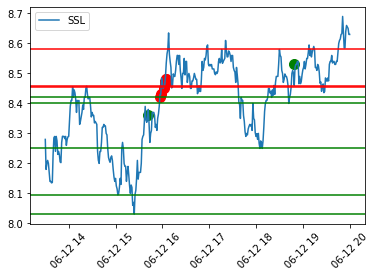

IMRN analysis for run 1497 with profit -96.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-658.92,-658.92,buy,2020-06-12 15:47:08.154933,12.92,"[11.0648, 12.1277]",[13.03],51,"{'avg': 12.6673, 'rsi': 57.44317242131179, 'macd': [0.05280691773633173, 0.10335710067303516, 0.12024562461862232, 0.16161474594786007, 0.1866086188303342], 'vwap': 12.9394, 'supports': [9.71, 9.865, 11.0648, 11.5357, 12.12, 12.91], 'sell_macd': [0.050456279486542854, 0.08229394096025011, 0.09200778183638114, 0.1175976866510755, 0.13237946070601936], 'slow macd': [0.0816419632298846, 0.08997078390834012, 0.09317139696131527, 0.10188308230599752, 0.10861721091410992], 'macd_signal': [-0.08731731266876168, -0.0491824300004023, -0.015296819076597377, 0.020085493928294118, 0.053390118908702135], 'resistances': [13.03, 14.25, 14.62, 15.6], 'position_ratio': '5.0', 'sell_macd_signal': [-0.04067708663312149, -0.016082881114447167, 0.005535251475718497, 0.0279477385107899, 0.048834082949835794]}",16.85,10.97
1,-333.42,325.50,sell,2020-06-12 15:47:12.580904,13.02,None,None,25,"{'avg': 12.6736, 'rsi': [59.00987491256734, 58.41013965482462], 'vwap': 13.0288, 'reasons': 'scale-out', 'movement': 0.007739938080495328, 'sell_macd': [0.08229394096025011, 0.09200778183638114, 0.1175976866510755, 0.1391327074592663, 0.15202840279734708], 'sell_macd_signal': [-0.016082881114447167, 0.005535251475718497, 0.0279477385107899, 0.05018473230048519, 0.07055346639985757]}",16.85,10.97
2,-163.77,169.65,sell,2020-06-12 15:47:17.004440,13.05,None,None,13,"{'avg': 12.6739, 'rsi': [59.00987491256734, 58.88894462002361], 'vwap': 13.001, 'reasons': 'scale-out', 'movement': 0.002457757296466976, 'sell_macd': [0.08229394096025011, 0.09200778183638114, 0.1175976866510755, 0.1391327074592663, 0.1536907404596839], 'sell_macd_signal': [-0.016082881114447167, 0.005535251475718497, 0.0279477385107899, 0.05018473230048519, 0.07088593393232492]}",16.85,10.97
3,-85.05,78.72,sell,2020-06-12 15:48:25.024018,13.12,None,None,6,"{'avg': 12.6771, 'rsi': [56.89232794265497, 58.4973047223153], 'vwap': 13.0761, 'reasons': 'scale-out', 'movement': 0.0007739463601532224, 'sell_macd': [0.09200778183638114, 0.1175976866510755, 0.1391327074592663, 0.14657385734280126, 0.15800626170214294], 'sell_macd_signal': [0.005535251475718497, 0.0279477385107899, 0.05018473230048519, 0.0694625573089484, 0.08717129818758731]}",16.85,10.97
4,-45.45,39.60,sell,2020-06-12 15:49:45.024638,13.20,None,None,3,"{'avg': 12.6798, 'rsi': [58.708150149592505, 59.75916789746133], 'vwap': 13.1817, 'reasons': 'scale-out', 'movement': 0.004192073170731821, 'sell_macd': [0.1175976866510755, 0.1391327074592663, 0.14657385734280126, 0.15904002793590877, 0.17162353712617673], 'sell_macd_signal': [0.0279477385107899, 0.05018473230048519, 0.0694625573089484, 0.08737805143434048, 0.10422714857270773]}",16.85,10.97
5,-19.15,26.30,sell,2020-06-12 15:49:53.780193,13.15,None,None,2,"{'avg': 12.6802, 'rsi': [58.708150149592505, 59.37823459384697], 'vwap': 13.1356, 'reasons': 'scale-out', 'movement': -0.004545454545454449, 'sell_macd': [0.1175976866510755, 0.1391327074592663, 0.14657385734280126, 0.15904002793590877, 0.169805355307993], 'sell_macd_signal': [0.0279477385107899, 0.05018473230048519, 0.0694625573089484, 0.08737805143434048, 0.10386351220907099]}",16.85,10.97
6,-6.00,13.15,sell,2020-06-12 15:50:06.849189,13.15,None,None,1,"{'avg': 12.6811, 'rsi': [58.708150149592505, 59.48780662272228], 'vwap': 13.1109, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.1175976866510755, 0.1391327074592663, 0.14657385734280126, 0.15904002793590877, 0.17032483582747382], 'sell_macd_signal': [0.0279477385107899, 0.05018473230048519, 0.0694625573089484, 0.08737805143434048, 0.10396740831296715]}",16.85,10.97
7,7.20,13.20,sell,2020-06-12 15:50:08.914833,13.20,None,None,1,"{'avg': 12.6814, 'rsi': [59.82267979421609, 59.89316031091555], 'vwap': 13.1657, 'reasons': 'scale-out', 'movement': 0.0028136882129276833, 'sell_macd': [0.1391327074592663, 0.146573

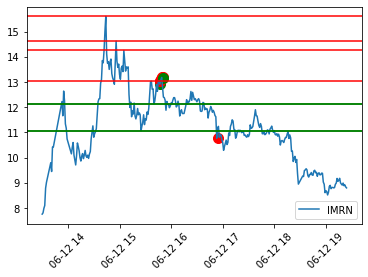

INO analysis for run 1497 with profit 41.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7142.85,-7142.85,buy,2020-06-12 15:47:23.561631,12.87,"[12.75, 12.75, 12.8462]",[12.9899],555,"{'avg': 12.8144, 'rsi': 69.21387461185043, 'macd': [0.00750322932341696, 0.008530389735895483, 0.011543345731586996, 0.016165538084546682, 0.02000155160228445], 'vwap': 12.8697, 'supports': [12.75, 12.75, 12.8462, 12.87], 'sell_macd': [0.005734789924002115, 0.006315089761470105, 0.008186556001556156, 0.01109696403277205, 0.013480438290436325], 'slow macd': [-0.0033655483879009296, -0.002885186727832334, -0.001976409068204177, -0.0006573354852061897, 0.0006372737336732825], 'macd_signal': [-0.0008071604240800093, 0.001060349607915089, 0.0031569488326494708, 0.005758666683028914, 0.00860724366688002], 'resistances': [12.9762, 12.98, 12.9899], 'position_ratio': 'inf', 'sell_macd_signal': [0.0005510357445627399, 0.001703846547944213, 0.003000388438666602, 0.004619703557487692, 0.006391850504077419]}",13.23,12.69
1,-3561.24,3581.61,sell,2020-06-12 15:57:42.495134,12.93,None,None,277,"{'avg': 12.8169, 'rsi': [64.98797497036387, 71.03507505421427], 'vwap': 12.9201, 'reasons': 'scale-out', 'movement': 0.004662004662004701, 'sell_macd': [0.01768671714375003, 0.016374824488039508, 0.017638611711019436, 0.017874827576832786, 0.019904673347898694], 'sell_macd_signal': [0.013882301875260947, 0.01438080639781666, 0.015032367460457215, 0.01560085948373233, 0.016461622256565604]}",13.23,12.69
2,-1759.80,1801.44,sell,2020-06-12 16:08:17.958817,12.96,None,None,139,"{'avg': 12.821, 'rsi': [68.2386394618468, 70.63826846340261], 'vwap': 12.955, 'reasons': 'scale-out', 'movement': 0.0019334880123743508, 'sell_macd': [0.01623333178455333, 0.01590475966679783, 0.01596165464430399, 0.016411681189836713, 0.017234926794280625], 'sell_macd_signal': [0.01768901913680198, 0.01733216724280115, 0.01705806472310172, 0.016928788016448718, 0.0169900157720151]}",13.23,12.69
3,41.64,1801.44,sell,2020-06-12 16:14:22.320356,12.96,None,None,139,"{'avg': 12.8239, 'rsi': [59.647820212009336, 65.20677039760179], 'vwap': 12.965, 'reasons': 'bail', 'movement': 0.0003858024691357257, 'sell_macd': [0.01910036925699643, 0.018607903854933383, 0.018242243751313225, 0.01668144050496778, 0.016547289397362164], 'sell_macd_signal': [0.017761237362055517, 0.01793057066063109, 0.01799290527876752, 0.01773061232400757, 0.01749394773867849]}",13.23,12.69


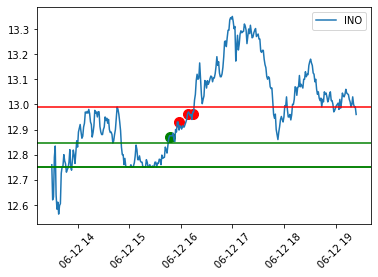

CAMP analysis for run 1507 with profit -670.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5450.97,-5450.97,buy,2020-06-12 18:56:35.735804,7.71,"[7.55, 7.595, 7.62, 7.63, 7.635, 7.66]",[7.71],707,"{'avg': 7.6264, 'rsi': 65.20019536400112, 'macd': [0.011307682895701276, 0.010565476251437111, 0.01305445422243956, 0.014855739479236796, 0.017693148276109127], 'vwap': 7.71, 'supports': [7.55, 7.595, 7.62, 7.635, 7.66, 7.69, 7.694], 'sell_macd': [0.007279990585062457, 0.006734041623317033, 0.008299093839835514, 0.009410834608034158, 0.0111938685234092], 'slow macd': [-0.002391669619275838, -0.002068606518399463, -0.0011283255822984728, -0.0002614324450345151, 0.0008564271465791862], 'macd_signal': [0.010037285629812261, 0.010142923754137232, 0.010725229847797698, 0.011551331774085518, 0.01277969507449024], 'resistances': [7.74, 7.74, 7.74, 7.75], 'position_ratio': '1.88', 'sell_macd_signal': [0.006751818229874852, 0.0067482629085632885, 0.007058429094817733, 0.007528910197461018, 0.008261901862650654]}",7.99,7.57
1,-2722.28,2728.69,sell,2020-06-12 19:12:28.799577,7.73,None,None,353,"{'avg': 7.6323, 'rsi': [55.253606774348384, 57.41030615262207], 'vwap': 7.73, 'reasons': 'scale-out', 'movement': 0.0025940337224384514, 'sell_macd': [0.00912433242041022, 0.009159200397844458, 0.0114050819335354, 0.011188819728443988, 0.011654215156574388], 'sell_macd_signal': [0.007179303216639564, 0.007575282652880542, 0.008341242509011514, 0.008910757952898009, 0.009459449393633284]}",7.99,7.57
2,-1352.30,1369.98,sell,2020-06-12 19:12:54.074853,7.74,None,None,177,"{'avg': 7.6325, 'rsi': [57.41030615262207, 58.83478305344806], 'vwap': 7.74, 'reasons': 'scale-out', 'movement': 0.0012936610608020422, 'sell_macd': [0.009159200397844458, 0.0114050819335354, 0.011188819728443988, 0.011654215156574388, 0.012384988020616383], 'sell_macd_signal': [0.007575282652880542, 0.008341242509011514, 0.008910757952898009, 0.009459449393633284, 0.010044557119029903]}",7.99,7.57
3,-670.30,682.00,sell,2020-06-12 19:18:07.416679,7.75,None,None,88,"{'avg': 7.633, 'rsi': [58.83478305344806, 60.26597580564427], 'vwap': 7.7499, 'reasons': 'scale-out', 'movement': 0.0012919896640826599, 'sell_macd': [0.0114050819335354, 0.011188819728443988, 0.011654215156574388, 0.012384988020616383, 0.0133130579403824], 'sell_macd_signal': [0.008341242509011514, 0.008910757952898009, 0.009459449393633284, 0.010044557119029903, 0.010698257283300403]}",7.99,7.57


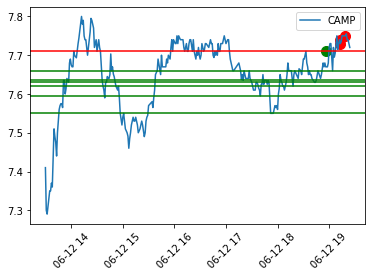

DSS analysis for run 1507 with profit -71.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3245.13,-3245.13,buy,2020-06-12 18:56:48.170120,9.09,"[8.75, 8.8101, 8.82, 8.85, 8.87, 8.95, 9.0101, 9.0101]","[9.0999, 9.0999, 9.1, 9.31, 9.36, 9.65]",357,"{'avg': 9.123, 'rsi': 59.22338813728069, 'macd': [-0.03791310952755467, -0.020653787161371895, -0.006896155254404235, 0.003331005416345789, 0.01272572097985325], 'vwap': 9.0982, 'supports': [7.92, 7.95, 8.1701, 8.36, 8.3601, 8.3601, 8.75, 8.87], 'sell_macd': [-0.02069188774470021, -0.00945872262279046, -0.0005827663898383406, 0.005930741926615468, 0.011853855654676337], 'slow macd': [0.007655016792464053, 0.009249672418642163, 0.010702013044856074, 0.01189474704275284, 0.013257762612919777], 'macd_signal': [-0.05473489548743733, -0.04791867382222424, -0.03971417010866024, -0.031105135003659034, -0.022338963806956574], 'resistances': [9.31, 9.36, 9.65], 'position_ratio': '0.91', 'sell_macd_signal': [-0.032367018252067684, -0.027785359126212238, -0.022344840578937458, -0.016689724077826873, -0.010981008131326232]}",9.66,8.82
1,-71.40,3173.73,sell,2020-06-12 19:47:48.888902,8.89,None,None,357,{'liquidation': 1},9.66,8.82


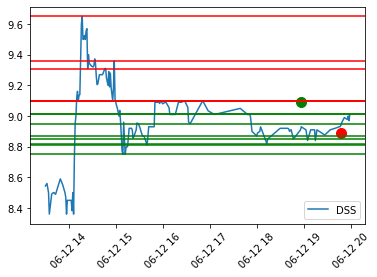

DRRX analysis for run 1505 with profit -78.54


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1656.48,-1656.48,buy,2020-06-12 18:56:11.049432,2.32,"[2.1927, 2.23]",[2.32],714,"{'avg': 2.2899, 'rsi': 64.72317970435121, 'macd': [0.007026599333986194, 0.006979544442081487, 0.007716700359340578, 0.009347045304664903, 0.010916722452087857], 'vwap': 2.32, 'supports': [2.23, 2.2744, 2.275, 2.285, 2.295, 2.32], 'sell_macd': [0.005009264629473709, 0.004913995572413121, 0.005331785975061898, 0.006330950107319655, 0.007287039689503061], 'slow macd': [-0.0016309993326570904, -0.0013841910798495505, -0.0009837742249798609, -0.0003850959842939261, 0.0002462910671874319], 'macd_signal': [0.002890047700486692, 0.003707947048805651, 0.004509697710912636, 0.0054771672296630896, 0.006565078274148043], 'resistances': [2.325, 2.34, 2.35, 2.355], 'position_ratio': 'inf', 'sell_macd_signal': [0.002499762058909937, 0.0029826087616105735, 0.0034524442043008382, 0.004028145384904602, 0.0046799242458242934]}",2.6,2.18
1,-78.54,1577.94,sell,2020-06-12 19:45:10.214031,2.21,None,None,714,{'liquidation': 1},2.6,2.18


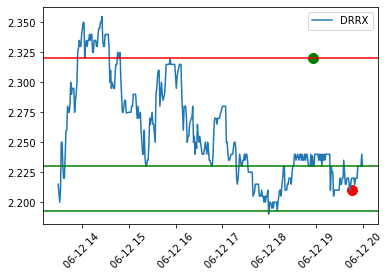

CBAY analysis for run 1505 with profit 28.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2945.25,-2945.25,buy,2020-06-12 18:59:43.722180,3.57,"[3.475, 3.5, 3.51]","[3.625, 3.64, 3.648, 3.71]",825,"{'avg': 3.4613, 'rsi': 69.96358315630651, 'macd': [0.006705178617422369, 0.007924805930186185, 0.009579786805654411, 0.010775230092067822, 0.012386757110288471], 'vwap': 3.57, 'supports': [3.43, 3.475, 3.485, 3.5, 3.51], 'sell_macd': [0.003948067863956961, 0.004737808206911609, 0.005805946029903364, 0.0065680541253527736, 0.0075960857045944685], 'slow macd': [0.00609263243743996, 0.006427602023370671, 0.006883841371284838, 0.007294185783146556, 0.007819985762578696], 'macd_signal': [0.0051028691108767465, 0.0056672564747386345, 0.0064497625409217895, 0.007314856051150996, 0.008329236262978492], 'resistances': [3.625, 3.64, 3.648, 3.71], 'position_ratio': '0.92', 'sell_macd_signal': [0.0028962056177244447, 0.0032645261355618775, 0.0037728101144301747, 0.004331858916614695, 0.004984704274210649]}",3.81,3.45
1,-1462.05,1483.20,sell,2020-06-12 19:08:42.070301,3.60,None,None,412,"{'avg': 3.4633, 'rsi': [76.71334554690723, 78.18344941524045], 'vwap': 3.6, 'reasons': 'scale-out', 'movement': 0.008403361344537886, 'sell_macd': [0.011677263970661045, 0.011975122127629412, 0.012311438585947077, 0.012413614545857765, 0.012591756663374198], 'sell_macd_signal': [0.008358619793434201, 0.009081920260273244, 0.00972782392540801, 0.010264982049497962, 0.01073033697227321]}",3.81,3.45
2,28.88,1490.93,sell,2020-06-12 19:08:47.471751,3.61,None,None,413,"{'avg': 3.4641, 'rsi': [78.18344941524045, 80.79484897893644], 'vwap': 3.6002, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0027777777777777185, 'sell_macd': [0.011975122127629412, 0.012311438585947077, 0.012413614545857765, 0.012591756663374198, 0.01308651991516152], 'sell_macd_signal': [0.009081920260273244, 0.00972782392540801, 0.010264982049497962, 0.01073033697227321, 0.011201573560850872]}",3.81,3.45


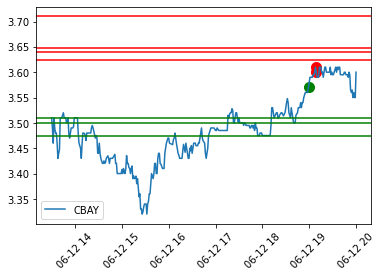

MBI analysis for run 1506 with profit -49.44


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4424.88,-4424.88,buy,2020-06-12 18:57:04.452776,7.16,"[6.985, 7.06, 7.08]",[7.17],618,"{'avg': 7.0429, 'rsi': 68.78100751678733, 'macd': [0.010276510150105445, 0.011190414901875556, 0.010981190249822248, 0.015478450818728895, 0.01962327376224504], 'vwap': 7.16, 'supports': [6.97, 7.0, 7.05, 7.05, 7.06, 7.07, 7.07, 7.08, 7.1], 'sell_macd': [0.006384808313346646, 0.006931371870874337, 0.006747767216079836, 0.009633948430317396, 0.01227728511114723], 'slow macd': [0.0015280778694108932, 0.002050110494757895, 0.0023671823176067974, 0.0036147287130905426, 0.0049166660746085], 'macd_signal': [0.012059337261818504, 0.011885552789829914, 0.01170468028182838, 0.012459434389208483, 0.013892202263815795], 'resistances': [7.36, 7.37, 7.38], 'position_ratio': '3.33', 'sell_macd_signal': [0.007859844888257165, 0.0076741502847805995, 0.007488873671040447, 0.007917888622895837, 0.008789767920546115]}",7.48,7.0
1,-49.44,4375.44,sell,2020-06-12 19:45:22.793246,7.08,None,None,618,{'liquidation': 1},7.48,7.0


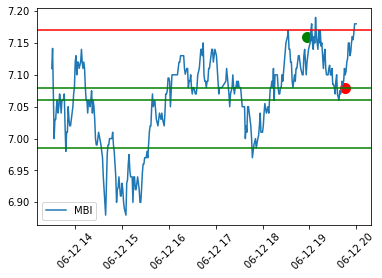

CLS analysis for run 1506 with profit 18.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7161.00,-7161.00,buy,2020-06-12 18:57:07.614819,6.51,"[6.42, 6.45, 6.48, 6.495]","[6.51, 6.51, 6.52]",1100,"{'avg': 6.456, 'rsi': 64.37864777376848, 'macd': [0.005624670424589695, 0.005491124228525379, 0.0061216379013684374, 0.006944728238766018, 0.007909317782439196], 'vwap': 6.51, 'supports': [6.42, 6.42, 6.45, 6.48, 6.485, 6.505], 'sell_macd': [0.003381387203305941, 0.0032718451231765755, 0.00366347668251521, 0.004180806771837631, 0.004789365195051687], 'slow macd': [-0.0007309942420041793, -0.0005193675809609388, -0.00016389760199864156, 0.00024337629324389098, 0.0006976600708448188], 'macd_signal': [0.007846880076094381, 0.007375728906580581, 0.007124910705538152, 0.007088874212183726, 0.00725296292623482], 'resistances': [6.52, 6.52, 6.52, 6.55, 6.55, 6.56], 'position_ratio': '2.0', 'sell_macd_signal': [0.0050312203368259745, 0.004679345294096094, 0.004476171571779918, 0.004417098611791461, 0.004491551928443506]}",6.69,6.42
1,-3575.00,3586.00,sell,2020-06-12 18:59:52.269528,6.52,None,None,550,"{'avg': 6.4584, 'rsi': [53.835893521734256, 63.76524442579529], 'vwap': 6.52, 'reasons': 'scale-out', 'movement': 0.001536098310291826, 'sell_macd': [0.0037443467804685326, 0.004030933300921191, 0.004201897689574352, 0.0037610660743734314, 0.004407676944680361], 'sell_macd_signal': [0.004419390656666316, 0.004341699185517292, 0.004313738886328704, 0.00420320432393765, 0.0042440988480861915]}",6.69,6.42
2,-1779.25,1795.75,sell,2020-06-12 19:00:29.265027,6.53,None,None,275,"{'avg': 6.4585, 'rsi': [63.76524442579529, 67.52624672829204], 'vwap': 6.53, 'reasons': 'scale-out', 'movement': 0.0015337423312884472, 'sell_macd': [0.004030933300921191, 0.004201897689574352, 0.0037610660743734314, 0.004407676944680361, 0.005373767532651286], 'sell_macd_signal': [0.004341699185517292, 0.004313738886328704, 0.00420320432393765, 0.0042440988480861915, 0.00447003258499921]}",6.69,6.42
3,-884.64,894.61,sell,2020-06-12 19:00:33.284163,6.53,None,None,137,"{'avg': 6.4586, 'rsi': [63.76524442579529, 67.52624672829204], 'vwap': 6.53, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.004030933300921191, 0.004201897689574352, 0.0037610660743734314, 0.004407676944680361, 0.005373767532651286], 'sell_macd_signal': [0.004341699185517292, 0.004313738886328704, 0.00420320432393765, 0.0042440988480861915, 0.00447003258499921]}",6.69,6.42
4,-433.38,451.26,sell,2020-06-12 19:03:10.106759,6.54,None,None,69,"{'avg': 6.4588, 'rsi': [70.79119791456257, 70.79119791456257], 'vwap': 6.54, 'reasons': 'scale-out', 'movement': 0.001531393568146981, 'sell_macd': [0.004407676944680361, 0.005373767532651286, 0.006576256724152074, 0.007427855357475366, 0.007994973054123555], 'sell_macd_signal': [0.0042440988480861915, 0.00447003258499921, 0.004891277412829783, 0.0053985930017589, 0.005917869012231831]}",6.69,6.42
5,-211.02,222.36,sell,2020-06-12 19:08:17.253703,6.54,None,None,34,"{'avg': 6.4599, 'rsi': [58.652592140595175, 65.22439677579202], 'vwap': 6.5314, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.007415528094323776, 0.007272496996746369, 0.006547115661014402, 0.006156596234975886, 0.006551560367478615], 'sell_macd_signal': [0.0061342839455332905, 0.006361926555775907, 0.006398964376823605, 0.006350490748454061, 0.006390704672258972]}",6.69,6.42
6,-99.67,111.35,sell,2020-06-12 19:08:54.944346,6.55,None,None,17,"{'avg': 6.46, 'rsi': [58.652592140595175, 68.55620539939558], 'vwap': 6.55, 'reasons': 'scale-out', 'movement': 0.0015290519877675516, 'sell_macd': [0.007415528094323776, 0.007272496996746369, 0.006547115661014402, 0.006156596234975886, 0.007071040886959423], 'sell_macd_signal': [0.0061342839455332905, 0.006361926555775907, 0.006398964376823605, 0.006350490748454061, 0.006494600776155134]}",6.69,6.42
7,-40.72,58.95,sell,2020-06-12 19:14:44.077093,6.55,None,None,9,"{'avg': 6.4612, 'rsi': [65.14810751714855, 65.14810751714855], 'vwap': 6.555, 'reasons': 'sc

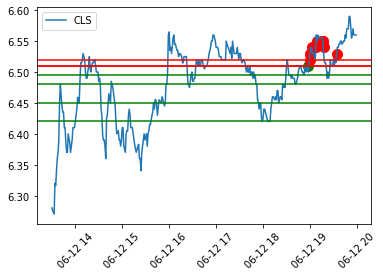

NOVA analysis for run 1506 with profit -4632.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4632.72,-4632.72,buy,2020-06-12 18:57:10.823051,15.92,"[15.407, 15.41, 15.49, 15.6, 15.63, 15.68, 15.8]",[15.92],291,"{'avg': 15.1134, 'rsi': 69.41796502862822, 'macd': [0.044699638956196, 0.04953773757328328, 0.05116829646047805, 0.059042172552036476, 0.07012236410465889], 'vwap': 15.92, 'supports': [15.3601, 15.407, 15.41, 15.41, 15.49, 15.595, 15.6, 15.63], 'sell_macd': [0.02765089531645515, 0.0306478562004191, 0.03154616525025489, 0.036511780545577466, 0.043543275833549444], 'slow macd': [0.023313348205972417, 0.02528234113416694, 0.02673356998792009, 0.029465414575101434, 0.0330512253455133], 'macd_signal': [0.03912037328527486, 0.041203846142876546, 0.043196736206396844, 0.04636582347552477, 0.0511171316013516], 'resistances': [16.5], 'position_ratio': '2.0', 'sell_macd_signal': [0.024693109787166136, 0.02588405906981673, 0.02701648030590436, 0.028915540353838982, 0.03184108744978108]}",16.6,15.58


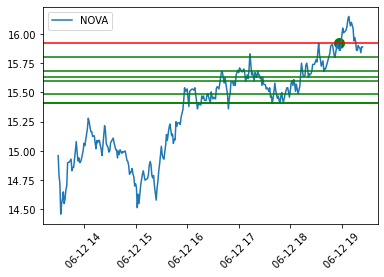

CNCE analysis for run 1508 with profit 23.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4559.28,-4559.28,buy,2020-06-12 18:57:04.589884,9.68,"[9.52, 9.525, 9.53, 9.53, 9.54, 9.54, 9.55, 9.575]","[9.68, 9.6884]",471,"{'avg': 9.5495, 'rsi': 67.10179532018964, 'macd': [0.0007012519646369952, 0.0033704022700753455, 0.004625486956443936, 0.00874698650324035, 0.01666272561821458], 'vwap': 9.6972, 'supports': [9.47, 9.48, 9.52, 9.53, 9.53, 9.53, 9.53, 9.54, 9.54, 9.54, 9.55, 9.56, 9.6], 'sell_macd': [0.0005291294807712177, 0.0022483320635515724, 0.003039290802552941, 0.005694073056288218, 0.010805668668856683], 'slow macd': [0.0008342081210628294, 0.0013566377827984866, 0.001675184004518826, 0.002605321597544119, 0.004416527241351886], 'macd_signal': [0.003155956632469793, 0.003198845759990903, 0.0034841739992815097, 0.0045367365000732775, 0.006961934323701538], 'resistances': [9.86, 9.86, 9.91], 'position_ratio': '1.89', 'sell_macd_signal': [0.002292203627057088, 0.002283429314355985, 0.002434601611995376, 0.0030864959008539443, 0.004630330454454492]}",10.11,9.48
1,23.55,4582.83,sell,2020-06-12 19:45:09.955006,9.73,None,None,471,{'liquidation': 1},10.11,9.48


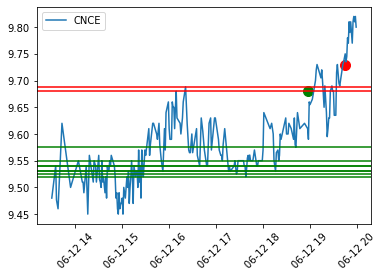

SSL analysis for run 1503 with profit 19.25


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4222.35,-4222.35,buy,2020-06-12 18:56:07.456445,8.53,"[8.25, 8.4, 8.42]",[8.58],495,"{'avg': 8.3247, 'rsi': 60.833465391389865, 'macd': [0.0012106859521381352, 0.0006602444403078778, 0.003867046737987323, 0.007133150569638147, 0.011206215958315724], 'vwap': 8.522, 'supports': [8.25, 8.29, 8.4, 8.42, 8.4958], 'sell_macd': [-0.001039997224848932, -0.0013162514286193527, 0.0008596057038801064, 0.00306339560317781, 0.005779811166227944], 'slow macd': [0.007395988594691261, 0.007251199916721518, 0.00783730005759331, 0.008523932294266956, 0.009461895128097808], 'macd_signal': [0.01641663684844711, 0.013265358366819264, 0.011385696041052875, 0.01053518694676993, 0.010669392749079088], 'resistances': [8.58, 8.595, 8.61], 'position_ratio': '1.46', 'sell_macd_signal': [0.008968838061828698, 0.006911820163739087, 0.0057013772717672915, 0.005173780938049395, 0.005294986983685105]}",8.93,8.33
1,-2108.03,2114.32,sell,2020-06-12 19:07:33.852510,8.56,None,None,247,"{'avg': 8.3284, 'rsi': [59.48083234040605, 60.937241370687765], 'vwap': 8.56, 'reasons': 'scale-out', 'movement': 0.0035169988276671908, 'sell_macd': [0.007620397882183383, 0.007488904935994967, 0.008068405173561999, 0.009454140356425, 0.010930633481299523], 'sell_macd_signal': [0.006307751254454668, 0.006543981990762728, 0.006848866627322582, 0.007369921373143066, 0.008082063794774358]}",8.93,8.33
2,-1045.35,1062.68,sell,2020-06-12 19:08:19.870510,8.57,None,None,124,"{'avg': 8.3286, 'rsi': [62.478851066294396, 63.244157143999445], 'vwap': 8.5751, 'reasons': 'scale-out', 'movement': 0.0017640186915888242, 'sell_macd': [0.008068405173561999, 0.009454140356425, 0.010411152961818715, 0.01205543352496008, 0.013450256905004565], 'sell_macd_signal': [0.006848866627322582, 0.007369921373143066, 0.007978167690878196, 0.008793620857694574, 0.009724948067156573]}",8.93,8.33
3,-512.77,532.58,sell,2020-06-12 19:08:51.542487,8.59,None,None,62,"{'avg': 8.3291, 'rsi': [62.478851066294396, 65.90545603237395], 'vwap': 8.5823, 'reasons': 'scale-out', 'movement': 0.002917152858809843, 'sell_macd': [0.008068405173561999, 0.009454140356425, 0.010411152961818715, 0.01205543352496008, 0.014484023138770397], 'sell_macd_signal': [0.006848866627322582, 0.007369921373143066, 0.007978167690878196, 0.008793620857694574, 0.009931701313909738]}",8.93,8.33
4,-246.79,265.98,sell,2020-06-12 19:13:11.948987,8.58,None,None,31,"{'avg': 8.3312, 'rsi': [57.998843003679525, 60.91117547662036], 'vwap': 8.5899, 'reasons': 'scale-out', 'movement': -1.1641443538971705e-05, 'sell_macd': [0.014370144615263314, 0.015128549082460196, 0.01422953244543912, 0.014123421657560087, 0.014891083100023295], 'sell_macd_signal': [0.010819389974180454, 0.011681221795836402, 0.012190883925756946, 0.012577391472117574, 0.013040129797698719]}",8.93,8.33
5,-118.09,128.70,sell,2020-06-12 19:13:15.010942,8.58,None,None,15,"{'avg': 8.3312, 'rsi': [57.998843003679525, 60.23219971418675], 'vwap': 8.585, 'reasons': 'scale-out', 'movement': 0.0005827505827506738, 'sell_macd': [0.014370144615263314, 0.015128549082460196, 0.01422953244543912, 0.014123421657560087, 0.014636537645477787], 'sell_macd_signal': [0.010819389974180454, 0.011681221795836402, 0.012190883925756946, 0.012577391472117574, 0.012989220706789617]}",8.93,8.33
6,-49.37,68.72,sell,2020-06-12 19:14:39.301520,8.59,None,None,8,"{'avg': 8.3314, 'rsi': [59.514613856338805, 61.02920779776312], 'vwap': 8.59, 'reasons': 'scale-out', 'movement': 0.0011655011655011406, 'sell_macd': [0.015128549082460196, 0.01422953244543912, 0.014123421657560087, 0.014376797385738271, 0.014907001883205595], 'sell_macd_signal': [0.011681221795836402, 0.012190883925756946, 0.012577391472117574, 0.012937272654841714, 0.01333121850051449]}",8.93,8.33
7,-15.01,34.36,sell,2020-06-12 19:14:40.958232,8.59,None,None,4,"{'avg': 8.3314, 'rsi': [59.514613856338805, 61.02920779776312], 'vwap': 8.59, 'reasons': 'scale-out', 'movement':

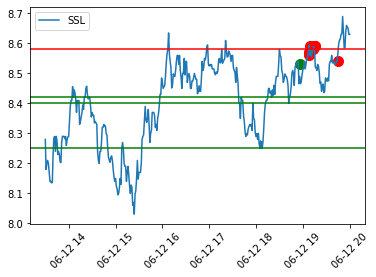

RWT analysis for run 1503 with profit 15.44


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4369.26,-4369.26,buy,2020-06-12 18:58:31.499823,7.07,"[6.92, 6.94, 6.955, 6.965]","[7.1, 7.185]",618,"{'avg': 6.915, 'rsi': 62.201788146089676, 'macd': [0.011040189351573915, 0.012547512919049986, 0.013984333230673052, 0.014950681529173337, 0.015936274281227014], 'vwap': 7.07, 'supports': [6.92, 6.94, 6.955, 6.965, 6.975, 7.055], 'sell_macd': [0.0068279708114387105, 0.00777520778682117, 0.008672078056121357, 0.009258313615886138, 0.009854622966146032], 'slow macd': [0.0019494888030733293, 0.0026074436605005857, 0.003288580946505526, 0.003909989411643444, 0.004555419607819466], 'macd_signal': [0.008554158122816569, 0.009352829082063252, 0.010279129911785211, 0.011213440235262837, 0.012158007044455672], 'resistances': [7.1, 7.185], 'position_ratio': '2.0', 'sell_macd_signal': [0.0053345304741619585, 0.005822665936693801, 0.006392548360579313, 0.006965701411640678, 0.007543485722541749]}",7.39,6.91
1,-2178.45,2190.81,sell,2020-06-12 19:00:11.458096,7.09,None,None,309,"{'avg': 6.9153, 'rsi': [61.82395108437932, 66.43608033201983], 'vwap': 7.0816, 'reasons': 'scale-out', 'movement': 0.0028288543140027682, 'sell_macd': [0.00777520778682117, 0.008672078056121357, 0.009258313615886138, 0.00976631127783456, 0.011162591127692245], 'sell_macd_signal': [0.005822665936693801, 0.006392548360579313, 0.006965701411640678, 0.007525823384879454, 0.008253176933442012]}",7.39,6.91
2,-1086.59,1091.86,sell,2020-06-12 19:00:19.625290,7.09,None,None,154,"{'avg': 6.9154, 'rsi': [66.43608033201983, 68.31670028894476], 'vwap': 7.099, 'reasons': 'scale-out', 'movement': 0.001396332863187591, 'sell_macd': [0.008672078056121357, 0.009258313615886138, 0.00976631127783456, 0.011162591127692245, 0.012619918398651286], 'sell_macd_signal': [0.006392548360579313, 0.006965701411640678, 0.007525823384879454, 0.008253176933442012, 0.009126525226483866]}",7.39,6.91
3,-539.89,546.70,sell,2020-06-12 19:02:38.438212,7.10,None,None,77,"{'avg': 6.9159, 'rsi': [67.63421968166493, 67.98757368230184], 'vwap': 7.1, 'reasons': 'scale-out', 'movement': 0.0014104372355429884, 'sell_macd': [0.00976631127783456, 0.011162591127692245, 0.012625113203845295, 0.01351246659820049, 0.014116735910707945], 'sell_macd_signal': [0.007525823384879454, 0.008253176933442012, 0.009127564187522669, 0.010004544669658232, 0.010826982917868174]}",7.39,6.91
4,-262.21,277.68,sell,2020-06-12 19:02:42.913000,7.12,None,None,39,"{'avg': 6.9166, 'rsi': [67.63421968166493, 69.91937252097404], 'vwap': 7.1018, 'reasons': 'scale-out', 'movement': 0.0014084507042254472, 'sell_macd': [0.00976631127783456, 0.011162591127692245, 0.012625113203845295, 0.01351246659820049, 0.014636216430188753], 'sell_macd_signal': [0.007525823384879454, 0.008253176933442012, 0.009127564187522669, 0.010004544669658232, 0.010930879021764336]}",7.39,6.91
5,-126.93,135.28,sell,2020-06-12 19:02:43.926367,7.12,None,None,19,"{'avg': 6.9166, 'rsi': [67.63421968166493, 69.91937252097404], 'vwap': 7.11, 'reasons': 'scale-out', 'movement': -0.001404494382022442, 'sell_macd': [0.00976631127783456, 0.011162591127692245, 0.012625113203845295, 0.01351246659820049, 0.014636216430188753], 'sell_macd_signal': [0.007525823384879454, 0.008253176933442012, 0.009127564187522669, 0.010004544669658232, 0.010930879021764336]}",7.39,6.91
6,-55.73,71.20,sell,2020-06-12 19:02:45.311264,7.12,None,None,10,"{'avg': 6.9166, 'rsi': [67.63421968166493, 69.91937252097404], 'vwap': 7.11, 'reasons': 'scale-out', 'movement': -0.001404494382022442, 'sell_macd': [0.00976631127783456, 0.011162591127692245, 0.012625113203845295, 0.01351246659820049, 0.014636216430188753], 'sell_macd_signal': [0.007525823384879454, 0.008253176933442012, 0.009127564187522669, 0.010004544669658232, 0.010930879021764336]}",7.39,6.91
7,-20.13,35.60,sell,2020-06-12 19:02:46.288808,7.12,None,None,5,"{'avg': 6.9167, 'rsi': [67.63421968166493, 71.63129026140899], 'vwap': 7.12, 'reasons': 'scale-out', 'mo

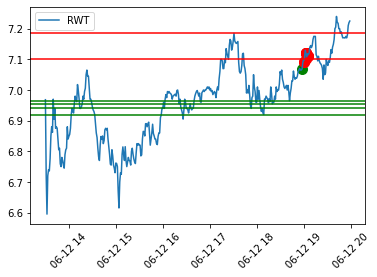

VSLR analysis for run 1504 with profit -4.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2855.16,-2855.16,buy,2020-06-12 18:56:09.431308,9.24,"[9.11, 9.18]",[9.24],309,"{'avg': 9.0549, 'rsi': 67.38052319697144, 'macd': [0.02125194522696283, 0.023067878175575984, 0.024227735862659472, 0.028051239909659742, 0.030727190488823553], 'vwap': 9.2344, 'supports': [8.995, 9.0701, 9.22, 9.23, 9.23], 'sell_macd': [0.014494580544784696, 0.015513761719960328, 0.016106451444512615, 0.01843703497735305, 0.02001363208115947], 'slow macd': [-0.0055060763674212865, -0.004289316105266394, -0.0031629975816169775, -0.0014819456370993578, 6.704608896335174e-05], 'macd_signal': [0.01374925301541217, 0.015612978047444933, 0.01733592961048784, 0.019478991670322222, 0.02172863143402249], 'resistances': [9.28, 9.28, 9.2813, 9.29], 'position_ratio': '4.0', 'sell_macd_signal': [0.010214726798016308, 0.011274533782405113, 0.012240917314826613, 0.0134801408473319, 0.014786839094097415]}",9.88,8.92
1,-1427.58,1427.58,sell,2020-06-12 19:38:13.564288,9.27,None,None,154,"{'avg': 9.0777, 'rsi': [65.86939883064579, 67.19968200920493], 'vwap': 9.27, 'reasons': 'scale-out', 'movement': 0.0032467532467531776, 'sell_macd': [-0.009932381480346919, -0.004351413571507479, 5.3904455789677286e-05, 0.004524880782827978, 0.008469474274249933], 'sell_macd_signal': [-0.010870905279985974, -0.009567006938290275, -0.0076428246594742845, -0.005209283571013832, -0.002473532001961079]}",9.88,8.92
2,-4.68,1422.90,sell,2020-06-12 19:45:06.248942,9.18,None,None,155,{'liquidation': 1},9.88,8.92


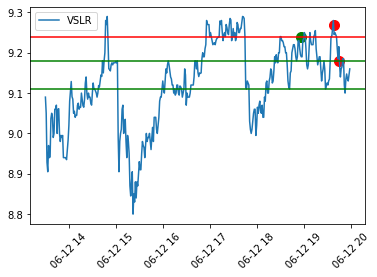

IMRN analysis for run 1490 with profit 53.05


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-833.82,-833.82,buy,2020-06-12 14:28:09.191350,10.69,"[7.45, 7.5999, 7.6, 7.66, 9.71, 9.865]",[12.64],78,"{'avg': 11.0029, 'rsi': 60.01783192625451, 'macd': [0.11740873923420025, 0.11128797008220559, 0.11296214843796726, 0.15366229218179228, 0.18221126756875883], 'vwap': 10.7303, 'supports': [9.71, 9.865], 'sell_macd': [0.03914512705093287, 0.036985920260640626, 0.03986204587520881, 0.068073805498571, 0.08813915318562593], 'slow macd': [0.41968167359670794, 0.4133605109149503, 0.4084351061271114, 0.41140547924133664, 0.41316205925687477], 'macd_signal': [0.2289084321944655, 0.2053843397720135, 0.18689990150520425, 0.18025237964052185, 0.18064415722616925], 'resistances': [12.64], 'position_ratio': '2.21', 'sell_macd_signal': [0.10653269423009025, 0.09262333943620032, 0.08207108072400202, 0.07927162567891581, 0.08104513118025783]}",13.29,9.45
1,-404.82,429.00,sell,2020-06-12 14:29:00.000091,11.00,None,None,39,"{'avg': 10.9973, 'rsi': [60.37547464408638, 62.40307361445805], 'vwap': 10.8342, 'reasons': 'scale-out', 'movement': 0.02245088868101031, 'sell_macd': [0.03914512705093287, 0.036985920260640626, 0.03986204587520881, 0.068073805498571, 0.09852876357523677], 'sell_macd_signal': [0.10653269423009025, 0.09262333943620032, 0.08207108072400202, 0.07927162567891581, 0.08312305325818001]}",13.29,9.45
2,-188.22,216.60,sell,2020-06-12 14:29:25.572394,11.40,None,None,19,"{'avg': 10.9991, 'rsi': [63.03841944627617, 67.09114971448497], 'vwap': 11.2878, 'reasons': 'scale-out', 'movement': 0.03635454545454551, 'sell_macd': [0.036985920260640626, 0.03986204587520881, 0.068073805498571, 0.10167162071809344, 0.147798858282421], 'sell_macd_signal': [0.09262333943620032, 0.08207108072400202, 0.07927162567891581, 0.08375162468675133, 0.09656107140588527]}",13.29,9.45
3,-71.22,117.00,sell,2020-06-12 14:35:01.617607,11.70,None,None,10,"{'avg': 11.0231, 'rsi': [61.94862711520863, 67.49159862427759], 'vwap': 11.6226, 'reasons': 'scale-out', 'movement': 0.024561403508771874, 'sell_macd': [0.14560592953549012, 0.1549407604707138, 0.16410373573880221, 0.17560600561343165, 0.20982068336491722], 'sell_macd_signal': [0.10520640666817008, 0.11515327742867883, 0.1249433690907035, 0.13507589639524914, 0.15002485378918276]}",13.29,9.45
4,-11.52,59.70,sell,2020-06-12 14:35:48.992923,11.94,None,None,5,"{'avg': 11.0507, 'rsi': [67.66932065703705, 69.80275329701313], 'vwap': 11.9011, 'reasons': 'scale-out', 'movement': 0.020512820512820534, 'sell_macd': [0.1549407604707138, 0.16410373573880221, 0.17560600561343165, 0.21085964440387706, 0.24805910781975804], 'sell_macd_signal': [0.11515327742867883, 0.1249433690907035, 0.13507589639524914, 0.15023264599697472, 0.1697979383615314]}",13.29,9.45
5,13.60,25.12,sell,2020-06-12 14:35:57.044983,12.56,None,None,2,"{'avg': 11.0693, 'rsi': [67.66932065703705, 72.52252348662006], 'vwap': 12.2377, 'reasons': 'scale-out', 'movement': 0.030150753768844324, 'sell_macd': [0.1549407604707138, 0.16410373573880221, 0.17560600561343165, 0.21085964440387706, 0.2667604065210565], 'sell_macd_signal': [0.11515327742867883, 0.1249433690907035, 0.13507589639524914, 0.15023264599697472, 0.17353819810179108]}",13.29,9.45
6,26.50,12.90,sell,2020-06-12 14:38:22.472788,12.90,None,None,1,"{'avg': 11.2791, 'rsi': [70.87056503724834, 75.99266812949902], 'vwap': 12.7982, 'reasons': 'scale-out', 'movement': 0.026273885350318476, 'sell_macd': [0.17560600561343165, 0.21085964440387706, 0.2622669000275515, 0.29613921739629134, 0.3566093449901615], 'sell_macd_signal': [0.13507589639524914, 0.15023264599697472, 0.17263949680309007, 0.19733944092173034, 0.22919342173541657]}",13.29,9.45
7,39.80,13.30,sell,2020-06-12 14:38:47.615353,13.30,None,None,1,"{'avg': 11.2858, 'rsi': [70.87056503724834, 77.90835267984771], 'vwap': 12.9869, 'reasons': 'scale-out', 'movement': 0.027131782945736406, 'sell_macd': [0.17560600561343165, 0.21085964440387706, 0.2622669000275515,

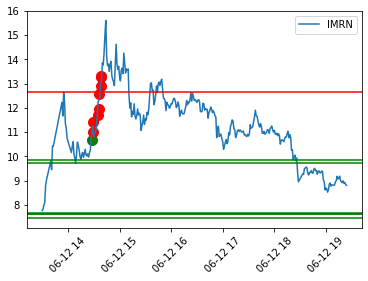

VSLR analysis for run 1493 with profit -107.71


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5746.68,-5746.68,buy,2020-06-12 14:44:05.180287,9.18,"[9.04, 9.0702, 9.09]","[9.9, 9.955]",626,"{'avg': 9.0346, 'rsi': 69.02180738936235, 'macd': [0.016643183267229134, 0.016480924476498515, 0.01736256303673578, 0.01875686603365523, 0.022722694694675027], 'vwap': 9.1769, 'supports': [8.36, 8.39, 8.935, 9.0702, 9.095], 'sell_macd': [0.008368867591535434, 0.008347336552350981, 0.009001372930228513, 0.009981123706104711, 0.012625330496319975], 'slow macd': [0.055309524943034205, 0.05446209700084559, 0.053835235712169194, 0.05335312904759704, 0.053443197039852564], 'macd_signal': [0.019560995635868626, 0.018944981403994605, 0.01862849773054284, 0.018654171391165316, 0.01946787605186726], 'resistances': [9.8, 9.9, 9.955], 'position_ratio': '7.29', 'sell_macd_signal': [0.009883524825585998, 0.009576287170938995, 0.009461304322796899, 0.009565268199458462, 0.010177280658830765]}",9.5,9.02
1,-1268.71,4477.97,sell,2020-06-12 15:03:23.232094,9.01,None,None,497,"{'avg': 9.0601, 'rsi': [54.05997038550217, 28.89755686224574], 'vwap': 9.0162, 'reasons': 'stopped', 'movement': -0.017973856209150235, 'sell_macd': [0.007664114468582284, 0.007021091093637466, 0.006236643124930552, 0.0057989350567844156, -0.0031836807762761765], 'sell_macd_signal': [0.012575006585545176, 0.011464223487163635, 0.010418707414717019, 0.009494752943130498, 0.006959066199249162]}",9.5,9.02
2,-107.71,1161.00,sell,2020-06-12 15:03:23.498194,9.00,None,None,129,"{'avg': 9.0601, 'rsi': [54.05997038550217, 28.89755686224574], 'vwap': 9.0162, 'reasons': 'stopped', 'movement': -0.017973856209150235, 'sell_macd': [0.007664114468582284, 0.007021091093637466, 0.006236643124930552, 0.0057989350567844156, -0.0031836807762761765], 'sell_macd_signal': [0.012575006585545176, 0.011464223487163635, 0.010418707414717019, 0.009494752943130498, 0.006959066199249162]}",9.5,9.02


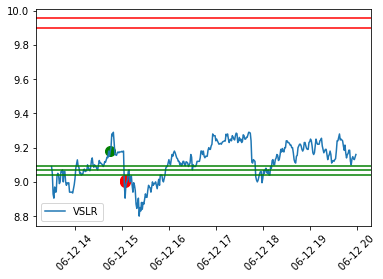

INSG analysis for run 1493 with profit -100.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7511.56,-7511.56,buy,2020-06-12 14:20:58.372787,9.73,[9.6501],[9.7864],772,"{'avg': 9.6254, 'rsi': 64.70717287866876, 'macd': [0.02105040258258306, 0.01814341841332201, 0.017645428897081317, 0.019846201453907142, 0.022939727514623698], 'vwap': 9.721, 'supports': [9.6, 9.6501], 'sell_macd': [0.010613404325839682, 0.008824313394054428, 0.008609121584948198, 0.010147814700125934, 0.012253967585976966], 'slow macd': [0.043766564808606745, 0.042918309468184646, 0.04246748628698427, 0.04254456981953325, 0.04286731709227176], 'macd_signal': [0.02443375663549619, 0.023175688991061354, 0.022069636972265348, 0.02162494986859371, 0.021887905397799706], 'resistances': [9.8645], 'position_ratio': '1.68', 'sell_macd_signal': [0.012358415432657274, 0.011651595024936704, 0.011043100336939003, 0.01086404320957639, 0.011142028084856506]}",9.99,9.6
1,-100.36,7411.20,sell,2020-06-12 14:36:11.620834,9.60,None,None,772,"{'avg': 9.637, 'rsi': [40.55622853267467, 36.03527440491477], 'vwap': 9.6254, 'reasons': 'stopped', 'movement': -0.013360739979445094, 'sell_macd': [-0.00039937008625301473, -0.002429569769946127, -0.003964406279710175, -0.006095909971994828, -0.009236095836477887], 'sell_macd_signal': [0.00864672377301463, 0.0064314650644224786, 0.004352290795595948, 0.002262650642077792, -3.7098653633343796e-05]}",9.99,9.6


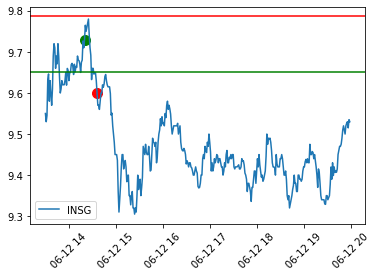

PGEN analysis for run 1492 with profit -487.34


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-995.92,-995.92,buy,2020-06-12 14:24:14.121902,4.22,"[3.855, 4.11]","[4.25, 4.43, 4.5]",236,"{'avg': 3.9988, 'rsi': 65.77536293705656, 'macd': [0.047169467583540126, 0.05413309370021935, 0.05897202477510799, 0.060495722628366444, 0.06100009305324594], 'vwap': 4.2247, 'supports': [3.68, 3.85, 3.855, 4.11], 'sell_macd': [0.027418802035266587, 0.031896661739016174, 0.034971660706365704, 0.035874625347075195, 0.03611232993273106], 'slow macd': [0.03700589171115798, 0.039268122597365895, 0.041286643500515474, 0.04275784303036101, 0.044043008462609556], 'macd_signal': [0.05263540587221139, 0.05293494343781298, 0.05414235970527198, 0.055413032289890876, 0.05653044444256189], 'resistances': [4.5], 'position_ratio': '2.25', 'sell_macd_signal': [0.031423010618622176, 0.031517740842700974, 0.03220852481543392, 0.032941744921762176, 0.03357586192395595]}",5.08,3.81
1,-487.34,508.58,sell,2020-06-12 14:26:13.913443,4.31,None,None,118,"{'avg': 4.0111, 'rsi': [58.50556465035262, 68.32124663177751], 'vwap': 4.2931, 'reasons': 'scale-out', 'movement': 0.021327014218009446, 'sell_macd': [0.031896661739016174, 0.034971660706365704, 0.035874625347075195, 0.0335201221405228, 0.03799817000372219], 'sell_macd_signal': [0.031517740842700974, 0.03220852481543392, 0.032941744921762176, 0.0330574203655143, 0.03404557029315588]}",5.08,3.81


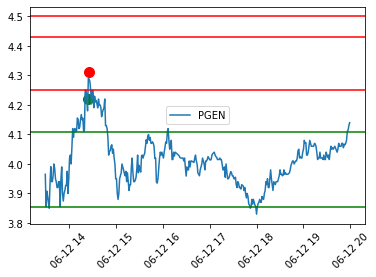

UNFI analysis for run 1492 with profit -107.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4040.64,-4040.64,buy,2020-06-12 14:46:26.768234,16.56,"[16.22, 16.24, 16.3]","[16.99, 17.1087]",244,"{'avg': 16.0804, 'rsi': 63.871835603478964, 'macd': [-0.01027274919001897, -0.0031822693921981227, 0.004802377394042878, 0.017784053623785212, 0.0321317024804344], 'vwap': 16.569, 'supports': [16.2143, 16.24, 16.3], 'sell_macd': [-0.012562953651070075, -0.007477628114337165, -0.0018594831751350682, 0.006958025649893784, 0.016590395829787496], 'slow macd': [0.11754900494830878, 0.11569122506783458, 0.11427678428205112, 0.11415213998568774, 0.11473294163067749], 'macd_signal': [0.011693337864295349, 0.008718216412996655, 0.0079350486092059, 0.009904849612121762, 0.014350220185784288], 'resistances': [16.99, 17.1087, 17.5725], 'position_ratio': '1.56', 'sell_macd_signal': [-8.276561939603473e-05, -0.0015617381183842607, -0.0016212871297344223, 9.457542619121899e-05, 0.0033937395069104743]}",17.39,16.16
1,-107.36,3933.28,sell,2020-06-12 14:53:24.477094,16.12,None,None,244,"{'avg': 16.0946, 'rsi': [43.12436010461915, 37.8623629551173], 'vwap': 16.1667, 'reasons': 'stopped', 'movement': -0.024154589371980593, 'sell_macd': [0.015075546701581288, 0.009835851013498598, 0.0035421160485817893, -0.002966536080553084, -0.013194491816495457], 'sell_macd_signal': [0.0075182643510061705, 0.007981781683504656, 0.0070938485565200824, 0.005081771629105449, 0.0014265189399852679]}",17.39,16.16


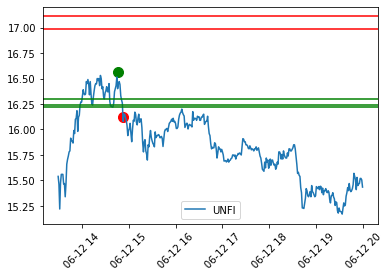

In [28]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))

In [ ]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
            
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()